# Caso practico de ML aplicado
## Estimación del precio de alquiler vacacional

A lo largo de este notebook se llevará a cabo el desarrollo de un modelo de machine learning, concretamente de regresión lineal, con el objetivo de aproximar una predicción sobre el precio de las estancias vacacionales, teniendo en cuenta algunos de los parámetros que se consideren relevantes a la hora de estimar el modelo de la manera más eficiente posible. Se realizarán los cambios que se consideren pertinentes para el buen desempeño del modelo.

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from datetime import datetime

In [319]:
import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")

In [320]:
#subimos el archivo y lo leemos con la funcion pd.read_csv de pandas
airbnb = pd.read_csv(r"/content/data/airbnb-listings-extract.csv", sep =";", parse_dates = ["Host Since", "Last Review", "First Review"])


#### ***Establecer np.random.seed() garantiza que los resultados aleatorios sean reproducibles en todo el notebook hasta que se reinicie el kernel.***

In [321]:
# creamos un diccionario para categorizar las variables de tipo objeto pora mejorar el rendimiento
cols = list(airbnb.columns)
cols_obj = [col for col in airbnb.columns if airbnb[col].dtype == 'object']
cat = ["category"] *49
dict_category = dict(zip(cols_obj, cat))

In [322]:
np.random.seed(42)

In [323]:
import os

# Crear el directorio si no existe
output_dir = './data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [324]:
train, test = train_test_split(airbnb, test_size=0.2, shuffle=True, random_state=42)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./data/airbnb_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/airbnb_test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


In [325]:
# A partir de este momento cargamos el dataset de train y trabajamos con él.
# 'dict_category' es un diccionario que contiene las columnas de tipo 'object' convertidas a tipo 'category'
# para mejorar el rendimiento y reducir el uso de memoria al trabajar con datos categóricos.
# visualizamos el DataFrame con una muestra de las 5 primeras filas
airbnb.head().T
airbnb_data = pd.read_csv(r'/content/data/airbnb_train.csv', sep=';', decimal='.', parse_dates = ["Host Since", "Last Review", "First Review"],
                         dtype = dict_category)
airbnb_test = pd.read_csv(r'/content/data/airbnb_test.csv', sep=';', decimal='.', parse_dates = ["Host Since", "Last Review", "First Review"],
                         dtype = dict_category)
airbnb_data.head(5).T

,0,1,2,3,4
ID,8494011,16865230,9695108,18088037,3137010
Listing Url,https://www.airbnb.com/rooms/8494011,https://www.airbnb.com/rooms/16865230,https://www.airbnb.com/rooms/9695108,https://www.airbnb.com/rooms/18088037,https://www.airbnb.com/rooms/3137010
Scrape ID,20170407214119,20170407214119,20170507222235,20170407214119,20170315084710
Last Scraped,2017-04-08,2017-04-08,2017-05-08,2017-04-08,2017-03-15
Name,CITY CENTER LATINA B ROOM 2,Tu SUITE en el corazón de MALASAÑA,Room in amazing Kreuzberg-Neukoln,Habitación con balcón en la Latina!,Vista Hermosa-Apartment
...,...,...,...,...,...
Cancellation Policy,strict,strict,flexible,strict,strict
Calculated host listings count,97.0,1.0,1.0,38.0,1.0
Reviews per Month,0.11,NaN,NaN,NaN,1.58
Geolocation,"40.4102231405,-3.70867805612","40.4272898629,-3.70437160544","52.4832726772,13.4425265568","40.4123714758,-3.71252881444","39.3674540905,3.22948720166"


In [326]:
print(airbnb_data.columns.to_list())
print(f"\nTenemos un total de: {len(airbnb_data.columns)} columnas y {airbnb_data.shape[0]} filas")

['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location', 'Host About', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Host Listings Count', 'Host Total Listings Count', 'Host Verifications', 'Street', 'Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights', 'Max

### ***Realizamos un anális exploratorio de los datos***

In [327]:
airbnb_data.describe() #resumen de las estadistico de las variables

,ID,Scrape ID,Host ID,Host Since,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,...,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,1.182400e+04,1.182400e+04,1.182400e+04,11822,10286.000000,11822.000000,11822.000000,11824.000000,11824.000000,11824.000000,...,9282,9169.000000,9149.000000,9154.000000,9142.000000,9156.000000,9139.000000,9139.000000,11821.000000,9283.000000
mean,1.026022e+07,2.017037e+13,3.605968e+07,2014-09-19 00:46:39.120284416,94.742660,12.542294,12.542294,40.497385,-3.838638,3.264970,...,2016-12-23 01:15:33.160956672,91.684371,9.412723,9.327616,9.618792,9.645151,9.532662,9.212058,9.478048,1.865575
min,1.862800e+04,2.016010e+13,1.745300e+04,2009-05-17 00:00:00,0.000000,0.000000,0.000000,-37.851182,-123.131344,1.000000,...,2012-08-04 00:00:00,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,5.556205e+06,2.017041e+13,6.773300e+06,2013-06-10 00:00:00,99.000000,1.000000,1.000000,40.409737,-3.707535,2.000000,...,2016-11-22 00:00:00,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,1.123371e+07,2.017041e+13,2.468248e+07,2014-12-15 00:00:00,100.000000,2.000000,2.000000,40.419453,-3.700769,3.000000,...,2017-03-07 00:00:00,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.190000
75%,1.531757e+07,2.017041e+13,5.434329e+07,2016-01-12 00:00:00,100.000000,6.000000,6.000000,40.430843,-3.684171,4.000000,...,2017-03-28 00:00:00,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.780000
max,1.858124e+07,2.017062e+13,1.247534e+08,2017-04-07 00:00:00,100.000000,519.000000,519.000000,55.956716,153.371427,16.000000,...,2017-06-11 00:00:00,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000
std,5.557168e+06,5.726876e+08,3.417099e+07,NaN,15.337695,34.215496,34.215496,4.590549,14.010897,2.091109,...,NaN,9.034297,0.930438,0.990421,0.801247,0.770007,0.777009,0.958257,23.630338,1.864372


#### Visualización del Mapa de Ubicaciones

Con el siguiente código podemos visualizar un mapa con las ubicaciones contenidas en el DataFrame.

Observamos que **España** cuenta con un total de **11,339 registros**, seguida por el **Reino Unido** con **160 registros**, **la zona de la costa este de EE. UU.** con **90 registros**, y **Europa continental** con **66 registros**. Este análisis muestra una clara descompensación en cuanto a la distribución de las localizaciones de los inmuebles.


In [328]:
from folium.plugins import FastMarkerCluster
Long=-42.70
Lat=40.00

# eliminamos los valos NaN de las columnas "Latitude" y "Longitude", creando un df limpio que lo usaremos solo para graficar las locaciones en el mapa
airbnb_data_copia = airbnb_data
airbnb_data_clean = airbnb_data_copia.dropna(subset=['Latitude', 'Longitude'])
locations = list(zip(airbnb_data_clean["Latitude"], airbnb_data_clean["Longitude"]))

#creamos un objeto para visuazlizar el mapa con las cordenadas de las locaciones
map1 = folium.Map(location=[Lat,Long], zoom_start=3)
FastMarkerCluster(data=locations).add_to(map1)
map1



In [329]:
# vamos a trabajar con las columnas de tipo fecha para intentar obtener información relevante
# previamente convetimos en formato fecha las columnas 'Host Since' y 'Last Review'
# procederemos a realizar calculos con ellas para posteriormente eliminarlas
# 'Host Since' menos 'Last Review' nos ayudara a obtener la antiguaded de una propiedad dentro de la oferta de airbnb

def calcular_antiguedad_host(df):
    """
    Esta funcion ayuda a crear la columna de antiguedad de una propiedad dentro del catalogo de oferta de airbnb
    """
    # Asegurarse de que las columnas estén en formato datetime
    df['Last Review'] = pd.to_datetime(df['Last Review'], errors='coerce')
    df['Host Since'] = pd.to_datetime(df['Host Since'], errors='coerce')

    # Calcular la diferencia en días y convertir a años
    df["Host_antiguedad_anios"] = (df["Last Review"] - df['Host Since']).dt.days
    df["Host_antiguedad_anios"] = round(df["Host_antiguedad_anios"] / 360, 0)  # Redondear a años

    return df

# Aplicar la función al DataFrame
airbnb_data = calcular_antiguedad_host(airbnb_data)
airbnb_test = calcular_antiguedad_host(airbnb_test)


In [330]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 90)
(2956, 90)


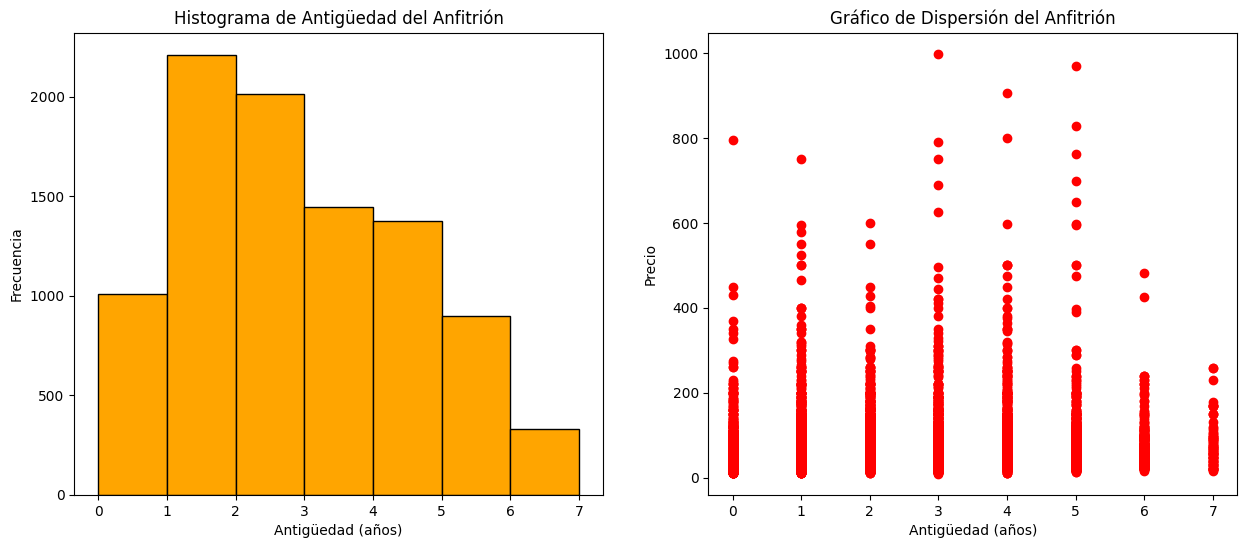

La correlación entre la antigüedad del anfitrión y el precio es de un: 10.576%


In [331]:
fig, (ax,ax1) = plt.subplots(figsize = (15,6), ncols = 2)
ax.hist(airbnb_data["Host_antiguedad_anios"], bins=7, color='orange', edgecolor='black')
ax.set_title('Histograma de Antigüedad del Anfitrión')
ax.set_xlabel('Antigüedad (años)')
ax.set_ylabel('Frecuencia')
ax1.scatter(airbnb_data["Host_antiguedad_anios"], airbnb_data["Price"], color = "r")
ax1.set_title('Gráfico de Dispersión del Anfitrión')
ax1.set_xlabel('Antigüedad (años)')
ax1.set_ylabel('Precio')
plt.show();
print(f"La correlación entre la antigüedad del anfitrión y el precio es de un: {round((airbnb_data['Host_antiguedad_anios'].corr(airbnb_data['Price'])) * 100,3)}%")


### Análisis del gráfico de dispersión

En el gráfico de dispersión se observa que, si bien no existe una relación claramente definida entre el precio y la antigüedad del piso, algunos inmuebles más antiguos tienden a tener un precio más elevado. Esto podría explicarse por factores como la ubicación o la demanda histórica.

La correlación entre ambas variables es del **10.56%**, lo que indica una relación débil. Sin embargo, se aprecia una ligera tendencia al alza en el precio conforme aumenta la antigüedad del inmueble.

---

**Gráfico de dispersión**  




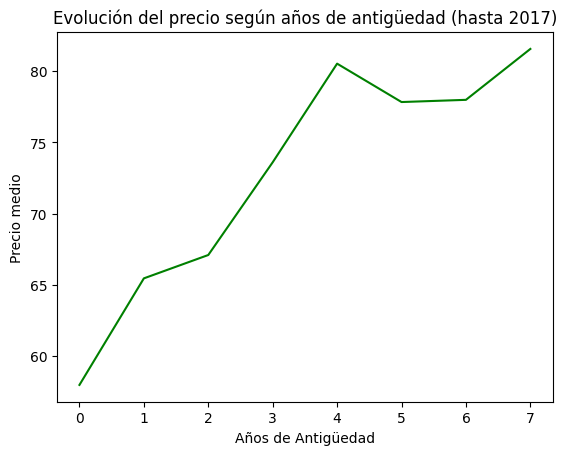

   Host_antiguedad_anios  Price
0                    0.0   58.0
1                    1.0   65.0
2                    2.0   67.0
3                    3.0   74.0
4                    4.0   81.0
5                    5.0   78.0
6                    6.0   78.0
7                    7.0   82.0


In [332]:
antiguedad = airbnb_data.groupby("Host_antiguedad_anios", as_index = False)["Price"].mean()
plt.plot(antiguedad["Host_antiguedad_anios"], antiguedad["Price"], color = "g")
plt.xlabel("Años de Antigüedad")
plt.ylabel("Precio medio")
plt.title("Evolución del precio según años de antigüedad (hasta 2017)")
plt.show();

print(antiguedad.round())

In [333]:
# vamos crear un columna con los años  para poder visualizar el precio según esta variable
airbnb_data["Año Hosting"] = airbnb_data["Host Since"].dt.year
airbnb_test["Año Hosting"] = airbnb_test["Host Since"].dt.year

### Conforme entraban más imnuebles al catálogo de Airbnb se puede apreciar unas subidas y recaidas, sin embargo del año 2013 al 2016 el precio desciende notariamente para luego recuperarse.

   Año Hosting  Price
0       2009.0  78.33
1       2010.0  91.51
2       2011.0  83.47
3       2012.0  79.85
4       2013.0  88.41
5       2014.0  67.89
6       2015.0  67.86
7       2016.0  65.73
8       2017.0  86.35


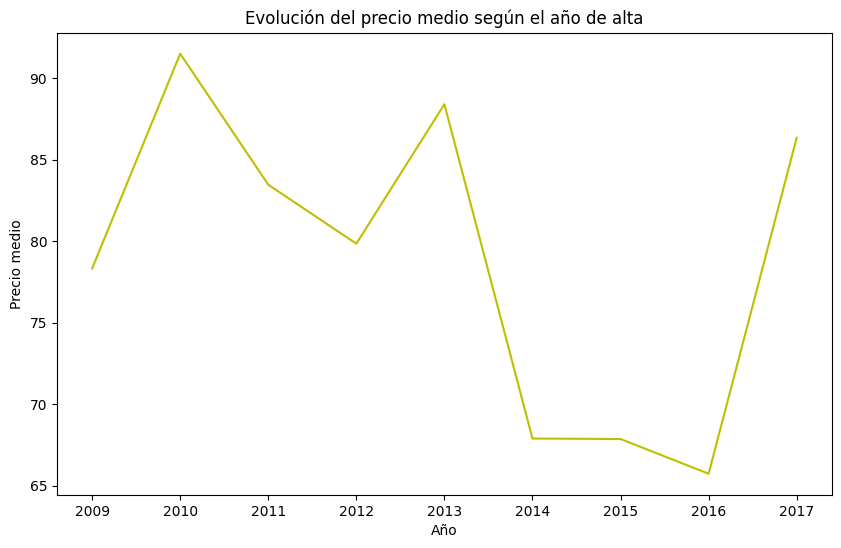

In [334]:
preciomedio_año = airbnb_data.groupby("Año Hosting", as_index = False)["Price"].mean().round(2)
print(preciomedio_año)
# realizamos un grafico para visulizar el precio segun el año de entrada del inmueble al mercado de alquiler
plt.figure(figsize = (10,6))
plt.plot(preciomedio_año["Año Hosting"], preciomedio_año["Price"], c= "y")
plt.xlabel("Año")
plt.ylabel("Precio medio")
plt.title("Evolución del precio medio según el año de alta")
plt.show();

### Tendencias en los precios de nuevas altas

El gráfico muestra que las **nuevas altas** experimentaron **picos de precios** en los años **2010** y **2013**, seguidos de una **caída** entre **2014 y 2016**. Posteriormente, se observa una **recuperación** en el año **2017**.  

Esto sugiere que los precios de las nuevas altas han mostrado **fluctuaciones significativas** a lo largo del tiempo, con períodos de crecimiento y contracción marcados.

---

**Gráfico de tendencias**  



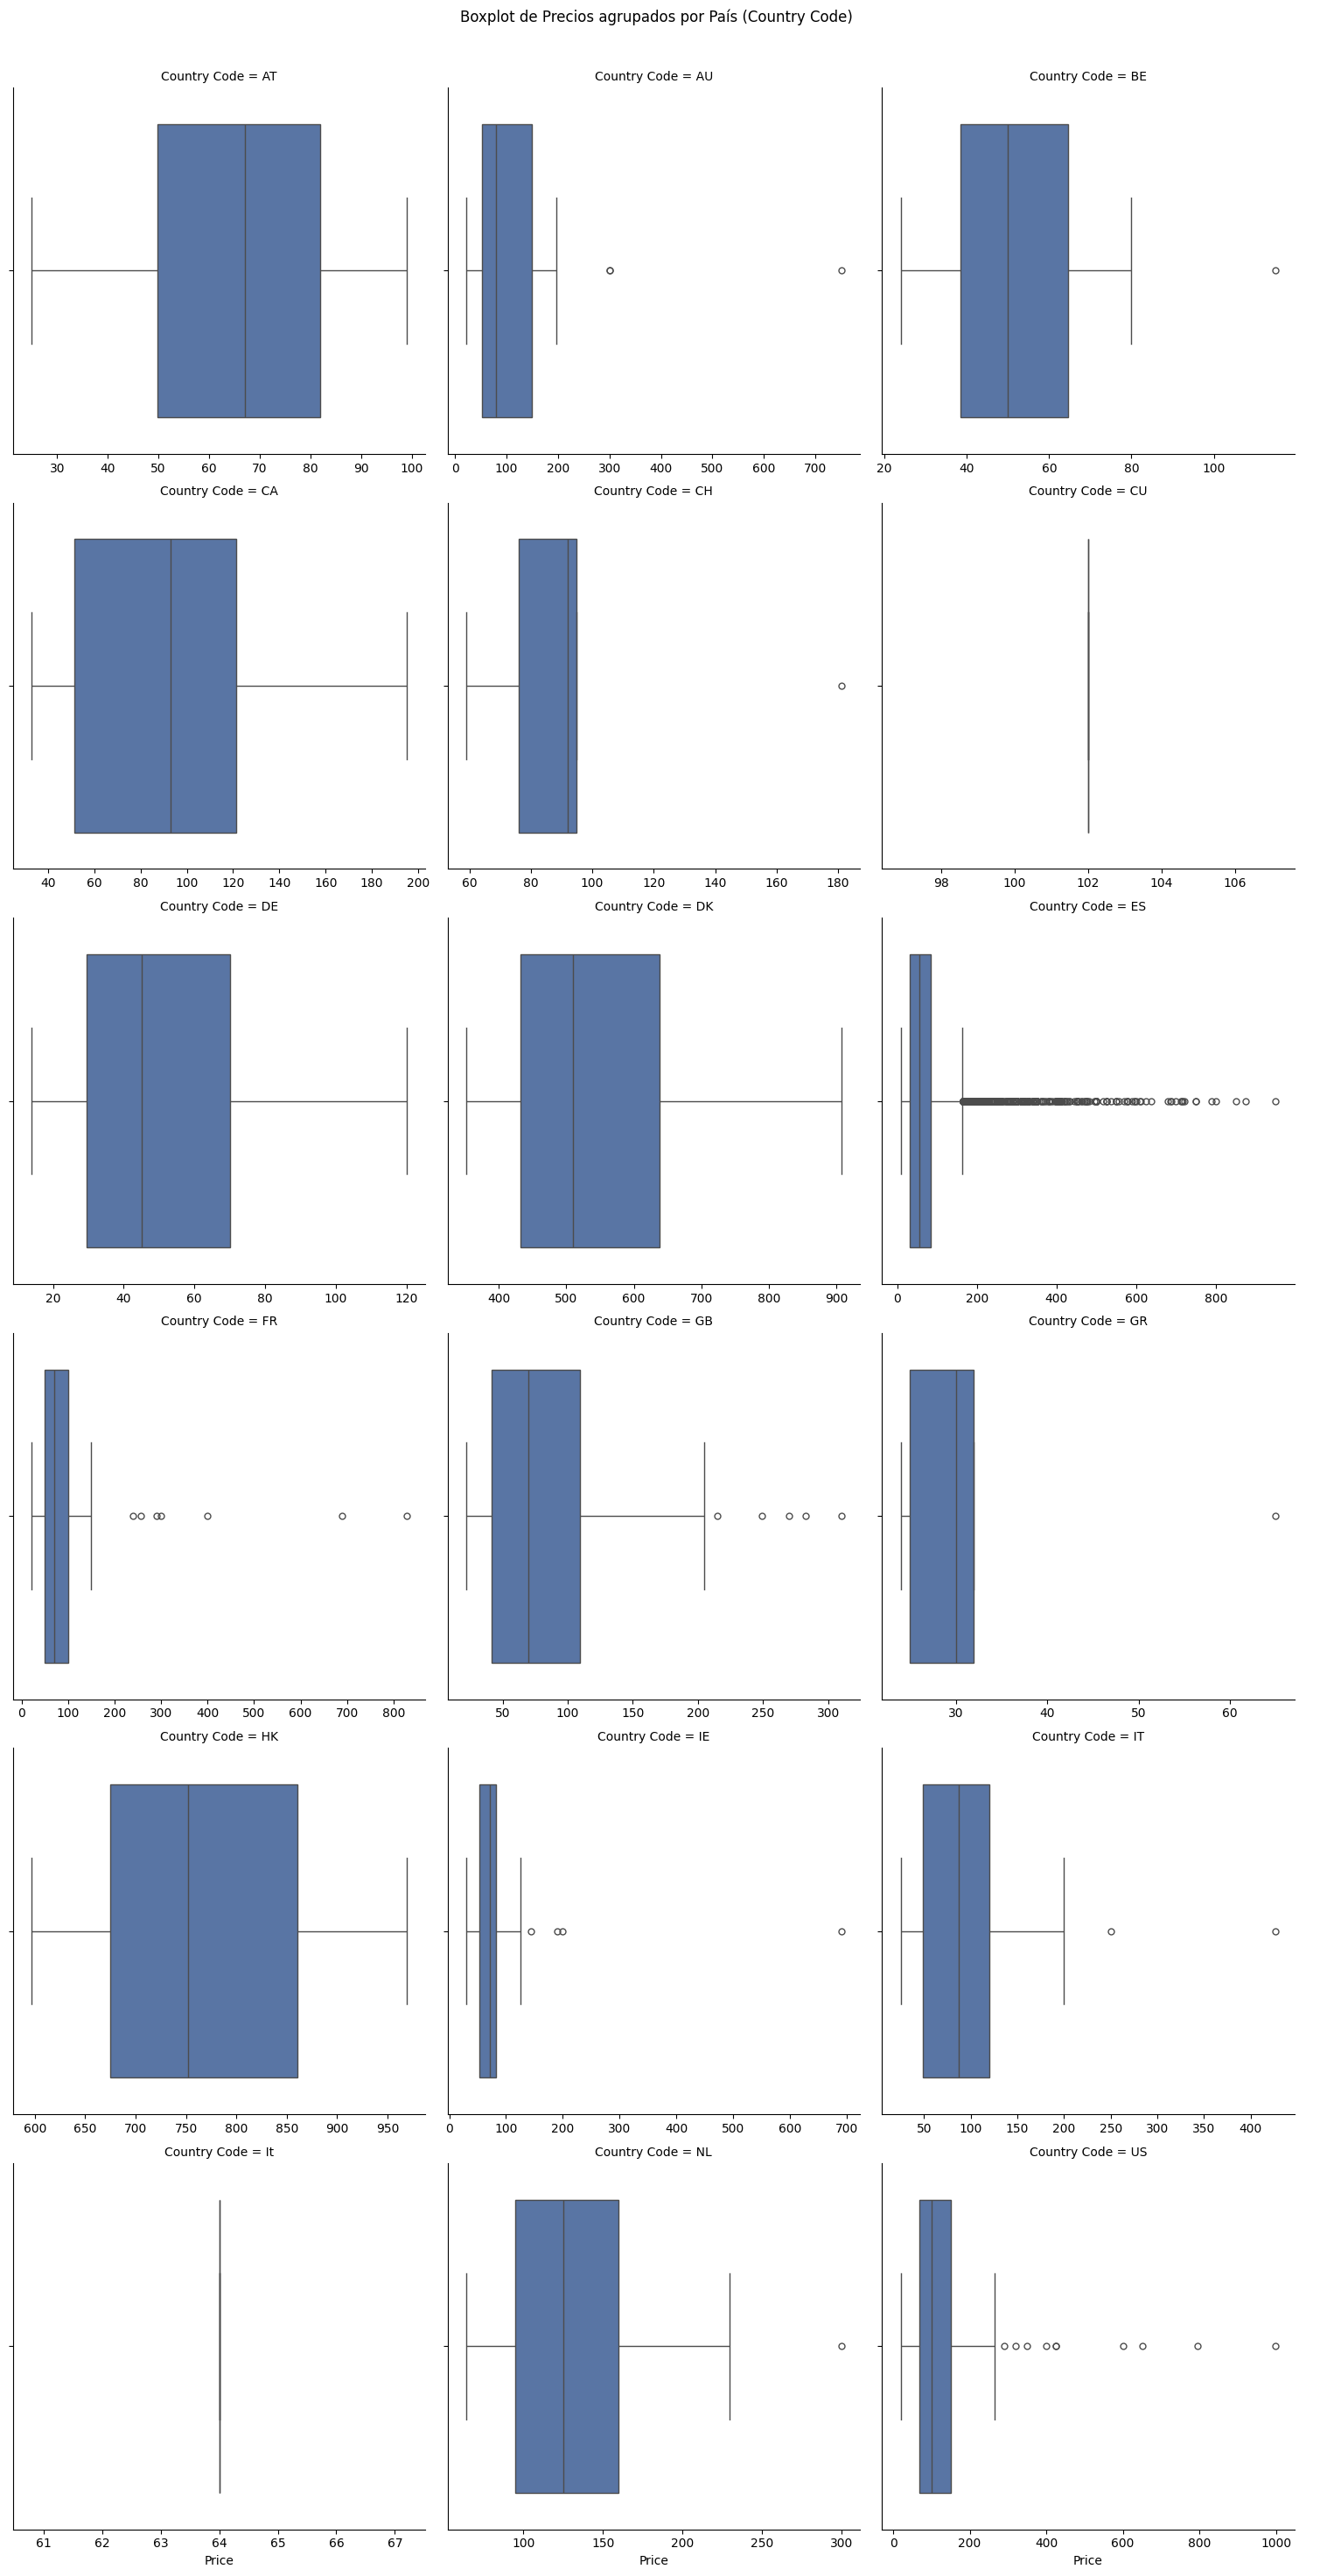

In [335]:
#plt.figure(figsize = (20,6))
sns.catplot(data = airbnb_data, x = "Price",  col="Country Code",  col_wrap=3, kind= "box", sharex=False )

plt.subplots_adjust(top=0.95)
plt.suptitle("Boxplot de Precios agrupados por País (Country Code)")
plt.show();

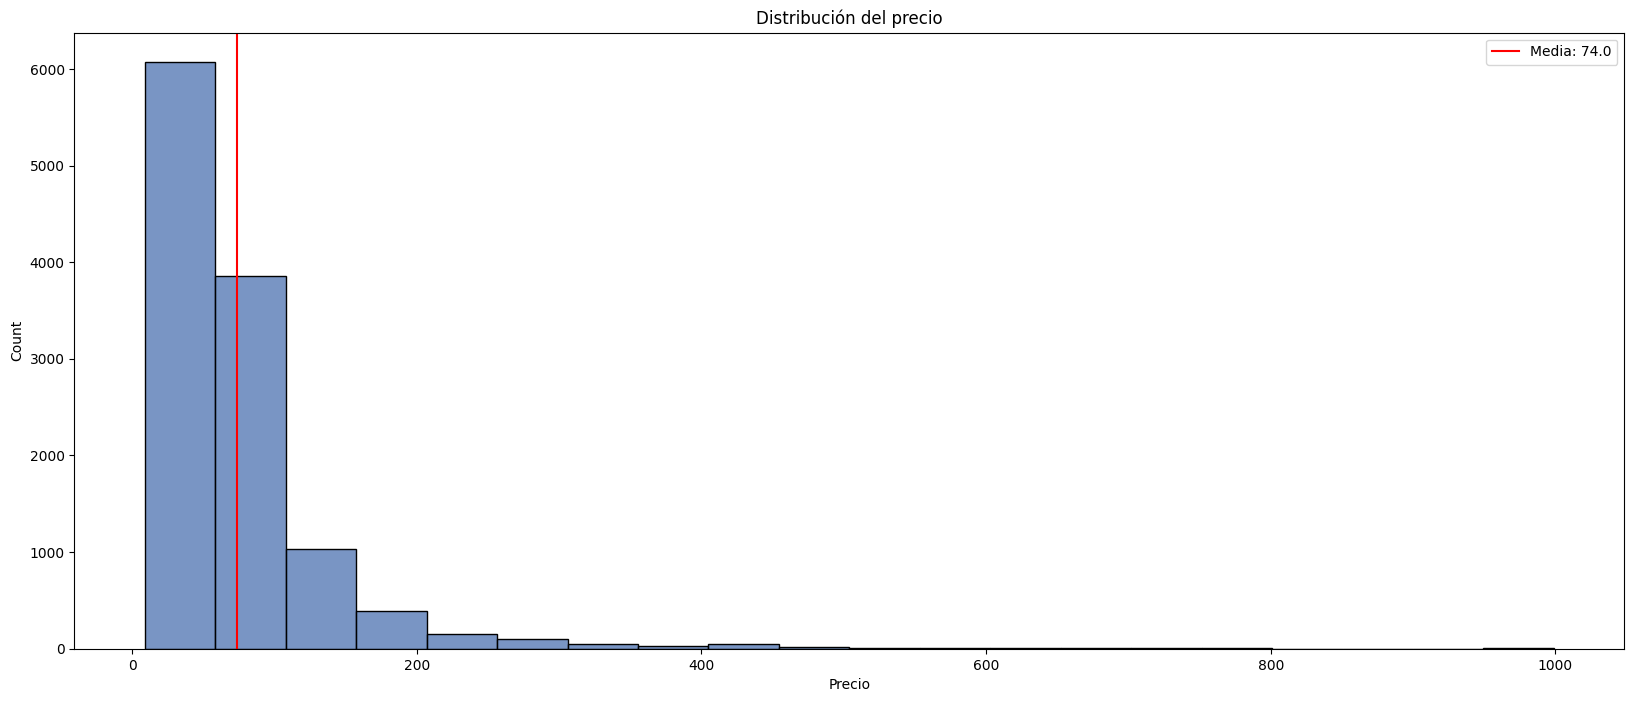

La media del Precio es de: 73.63


In [336]:
# vamos a analizar el precio para ver como se compone
media = airbnb_data["Price"].mean().round(2)
plt.figure(figsize = (20,8))

sns.histplot(data=airbnb_data, x="Price", bins = 20,palette="Set2")
plt.xlabel("Precio")
plt.title("Distribución del precio")
plt.axvline(airbnb_data["Price"].mean(), color = "red", label=f'Media: {media.round()}')
plt.legend()
plt.show();

# la distribucion del precio con los datos nativos del df muestran demasiados outliers
media = airbnb_data["Price"].mean().round(2)
print(f"La media del Precio es de: {media}")

In [337]:
# creamos las columnas de first y last review para por mes
def agregar_columnas_mes(df):
    df["Year-Month Last Review"] = df["Last Review"].dt.month
    df["Year-Month First Review"] = df["First Review"].dt.month
    df["Mes Hosting"] = df["Host Since"].dt.month

    return df

# Aplicar la función al conjunto de entrenamiento y de prueba
airbnb_data = agregar_columnas_mes(airbnb_data)
airbnb_test = agregar_columnas_mes(airbnb_test)

In [338]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 94)
(2956, 94)


In [339]:
# realizamos una tabla dinamica que nos devuelva el numero de entradas segun el mes, para analizar la ocupacion por mes.
ocupacion_por_mes= pd.pivot_table(airbnb_data, index = "Year-Month Last Review", values = "ID",aggfunc = "count").reset_index()
# agrupamos los datos para obtener el precio medio según el mes del año
precios_mes = airbnb_data.groupby("Year-Month First Review", as_index = False)["Price"].mean().round(2)

In [340]:
# reasignamos y cambiamos los datos de mes en formato numerico a formato de cadenas para una mejor visualización
meses = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ocupacion_por_mes.loc[: ,"Year-Month Last Review"] = meses
precios_mes.loc[: ,"Year-Month First Review"] = meses

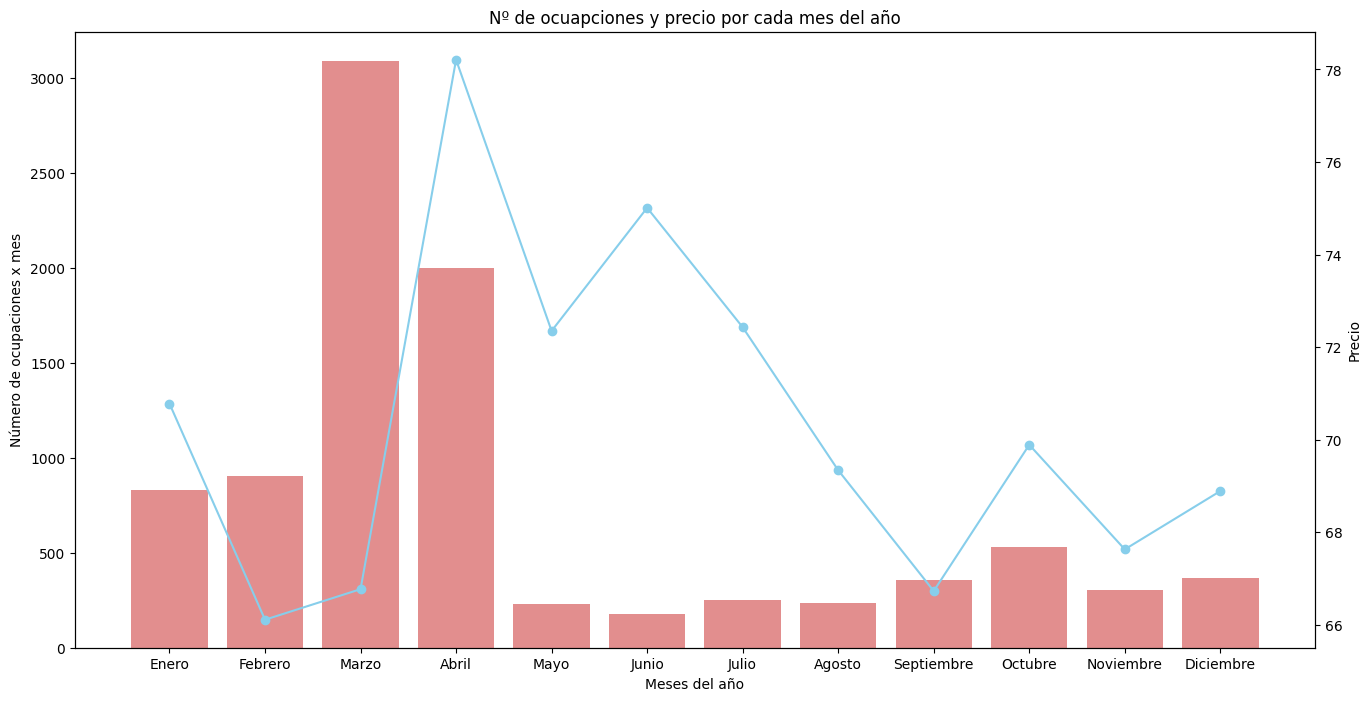

In [341]:
sns.set_palette("deep")
fig, ax1 = plt.subplots(figsize= (16,8))
sns.barplot(data = ocupacion_por_mes, x = "Year-Month Last Review", y = "ID", color = "lightcoral")
plt.title("Nº de ocuapciones y precio por cada mes del año")
plt.ylabel("Número de ocupaciones x mes")
plt.xlabel("Meses del año")

ax2 = ax1.twinx()
ax2.plot(precios_mes["Year-Month First Review"], precios_mes["Price"], color = "skyblue", marker = "o")
ax2.set_ylabel("Precio")
ax2.set_xlabel("Mes")

plt.show();
# vemos como los meses de mayor ocupación son los meses de septiembre y octubre seguido de marzo esto  nos puede decir que hay un mayor numero de visitas
# en otoño, ya que el verano o calor interior de madrid.

#### Relación entre Ocupación y Precios

Se observa una posible relación entre la **ocupación** y los **precios**. Cuando la cantidad de registros disminuye (menor ocupación), los precios tienden a bajar, especialmente en los meses de **junio** y **noviembre**.

No obstante, **marzo** sobresale al tener la **mayor ocupación**, pero con un precio relativamente bajo en comparación con **junio**.


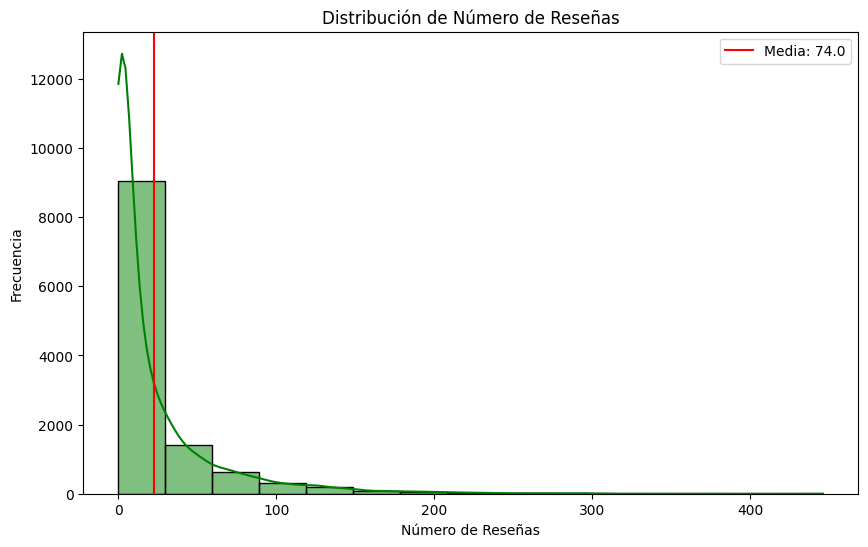

La media de las reseñas es de aproximadamente 74.0 reseñas.


In [342]:
# Histograma de 'Number of Reviews'
plt.figure(figsize=(10,6))
sns.histplot(airbnb_data['Number of Reviews'], bins=15, kde=True, color = "green")
plt.axvline(airbnb_data['Number of Reviews'].mean(), color = "red", label=f'Media: {media.round()}')
plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.legend()
plt.show();
print(f"La media de las reseñas es de aproximadamente {media.round()} reseñas.")


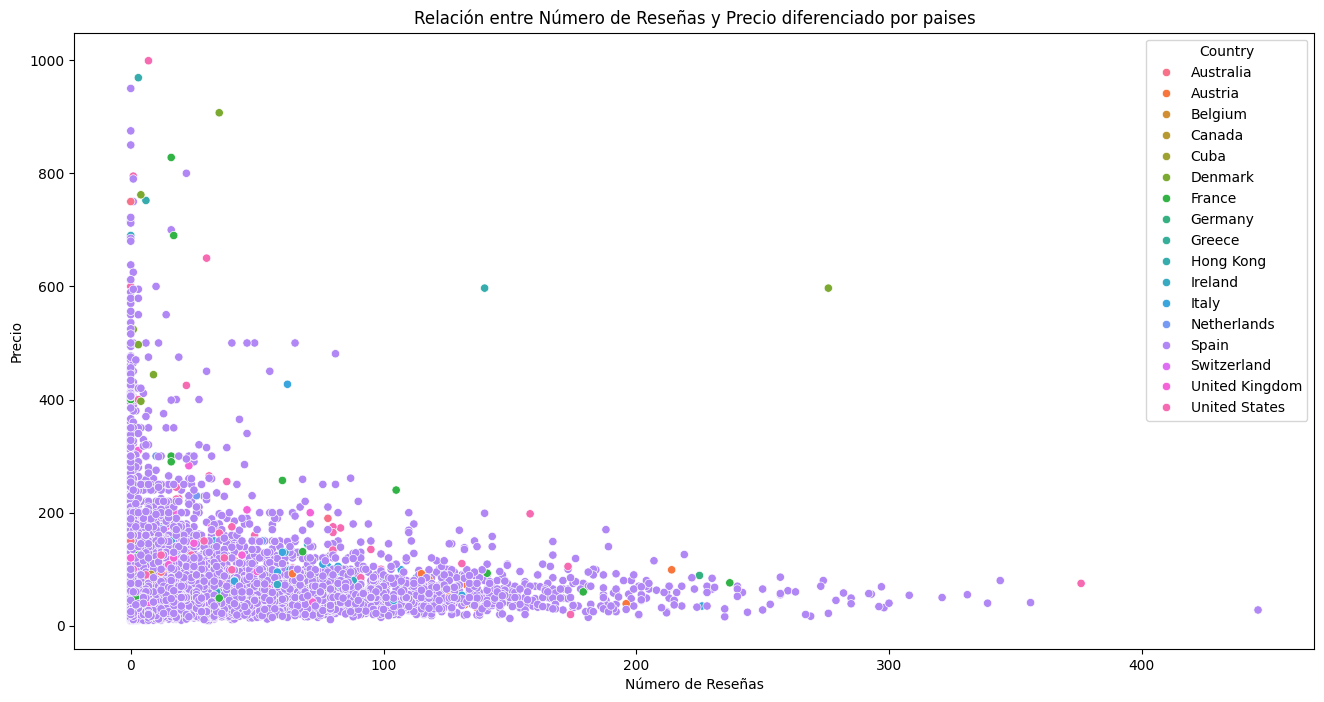

La correlacion entre el numero de reseñas y el precio es de:  -0.058761074114366665


In [343]:
# relacion entre el numero de reseñas y el precio
plt.figure(figsize=(16,8))
sns.scatterplot(x=airbnb_data['Number of Reviews'], y=airbnb_data['Price'], hue= 'Country', data = airbnb_data)
plt.title('Relación entre Número de Reseñas y Precio diferenciado por paises')
plt.xlabel('Número de Reseñas')
plt.ylabel('Precio')
plt.show()
print("La correlacion entre el numero de reseñas y el precio es de: ",airbnb_data['Number of Reviews'].corr(airbnb_data["Price"]))

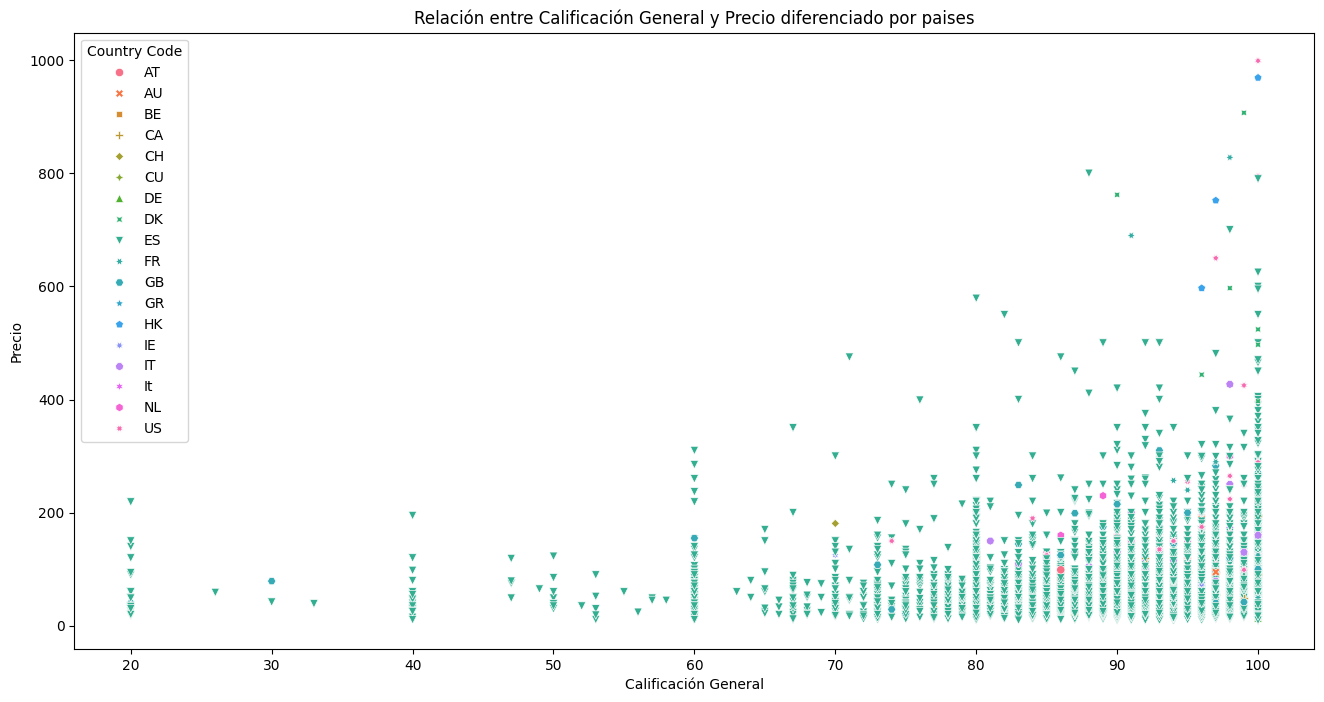

La correlación entre la calificación y el precio del inmueble es ligeramente psitiva 0.07160586611196569


In [344]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='Review Scores Rating', y='Price', style = "Country Code", hue = "Country Code" ,data = airbnb_data )
plt.title('Relación entre Calificación General y Precio diferenciado por paises')
plt.xlabel('Calificación General')
plt.ylabel('Precio')
plt.show()
print(f"La correlación entre la calificación y el precio del inmueble es ligeramente psitiva {airbnb_data['Review Scores Rating'].corr(airbnb_data['Price'])}")

#### Análisis de la Oferta y Precios por País

Aunque **España (ES)** domina el conjunto de datos con una amplia oferta a **precios bajos y moderados**, otros países como **Francia (FR)**, **Estados Unidos (US)** y **Reino Unido (GB)** muestran una tendencia a **precios más altos** cuando la calificación general es elevada. Esto podría reflejar diferencias en el mercado y el **valor percibido** d


0.25     34.0
0.50     55.0
0.75     87.0
0.99    404.0
Name: Price, dtype: float64


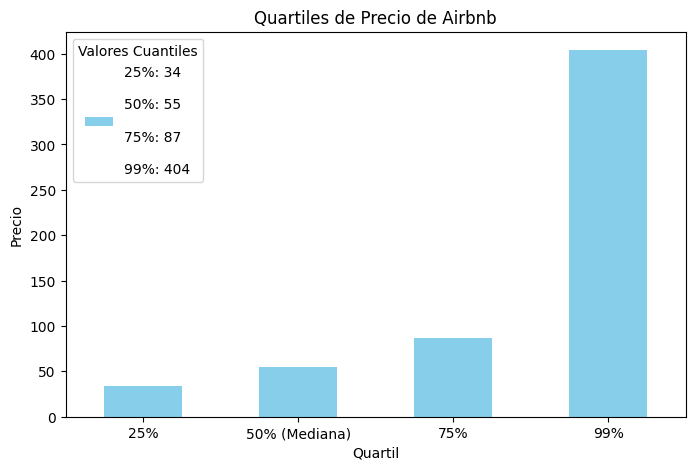

In [345]:
quartiles_precio = airbnb_data["Price"].quantile([0.25,0.50,0.75,0.99])
print(quartiles_precio)
plt.figure(figsize=(8, 5))
quartiles_precio.plot(kind='bar', color='skyblue')
# Añadir una leyenda con los valores de los cuantiles
legend_text = ["25%: 34\n\n50%: 55\n\n75%: 87\n\n99%: 404"]
plt.legend(legend_text, loc='upper left', fontsize=10, title="Valores Cuantiles")
# Personalización
plt.title('Quartiles de Precio de Airbnb')
plt.ylabel('Precio')
plt.xlabel('Quartil')
plt.xticks(range(len(quartiles_precio)), ['25%', '50% (Mediana)', '75%', '99%'], rotation=0)

plt.show()

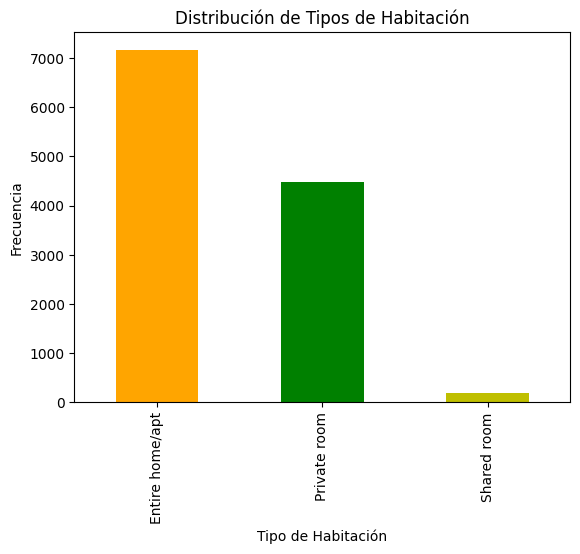

In [346]:
# Gráfico sobre el tipo de alojamiento: departamento entero, habitación privada o compartida
airbnb_data['Room Type'].value_counts().plot(kind='bar',color=['orange','green','y'])
plt.title('Distribución de Tipos de Habitación')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Frecuencia')
plt.show();

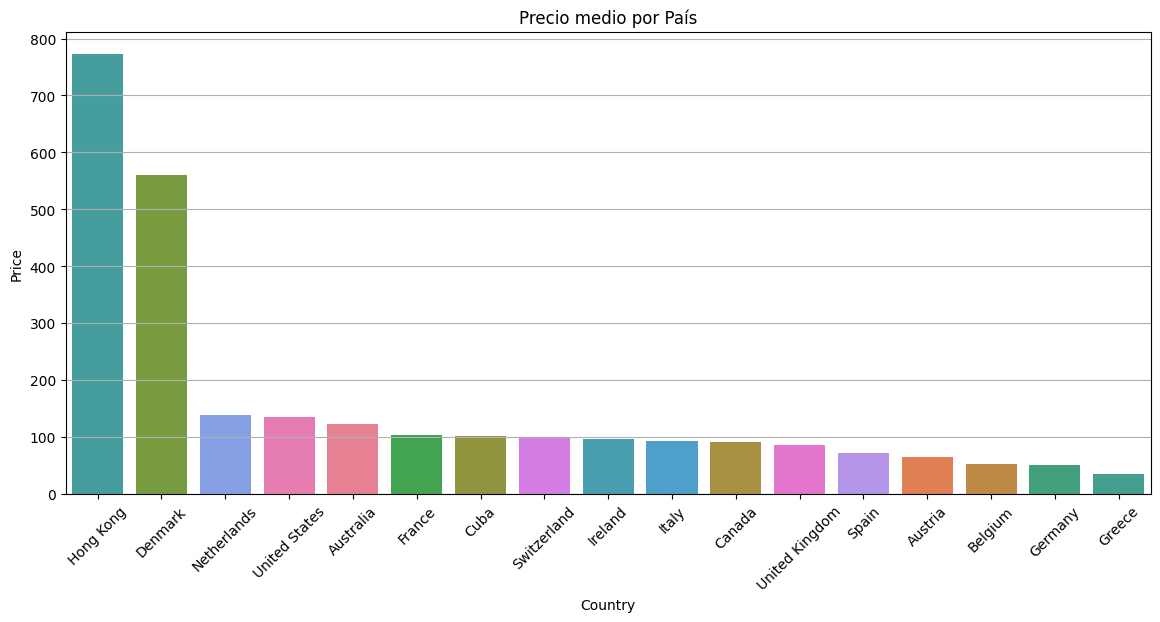

In [347]:
# precios medio por pais
price_country = airbnb_data.groupby(['Country'], as_index = False)['Price'].mean().sort_values(by = "Price",ascending = False)
columnas = price_country["Country"]
columnas

#creamos un gráfico con los precios medio por pais
plt.figure(figsize = (14,6))
plt.grid()
sns.barplot(data = price_country, x = "Country", y = "Price", order = columnas, hue = "Country")
plt.title("Precio medio por País")
plt.xticks(rotation = 45)
plt.show()

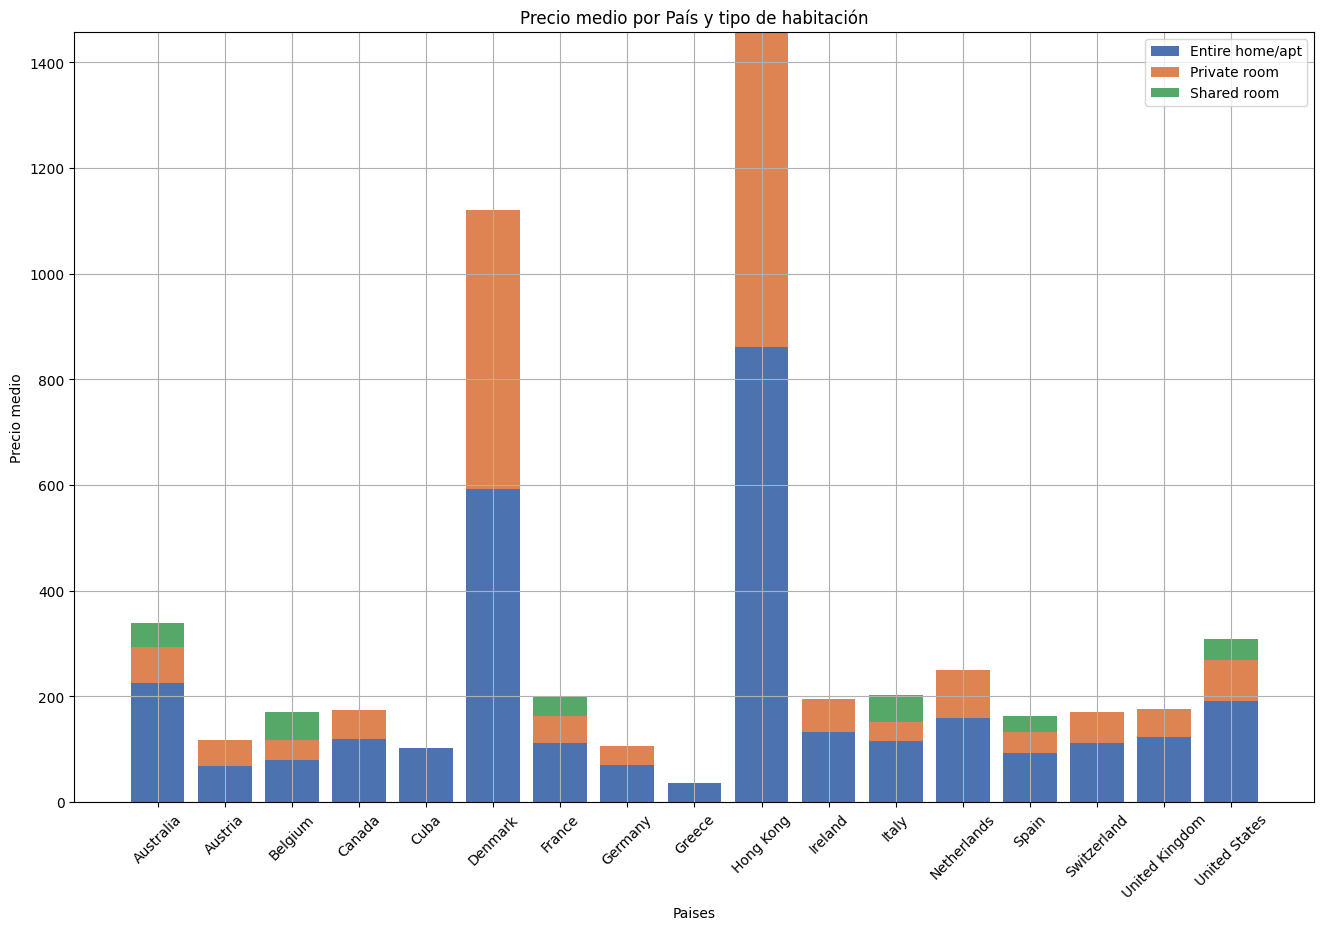

In [348]:
# creamos unta tabla dinamica para que muestre el precio en barras apiladas segun el pais y el tipo de habitación
country_price_room = airbnb_data.pivot_table(index = "Country", columns = "Room Type", values = "Price", aggfunc = "mean").reset_index().round(2)
country_price_room["Private room"]= country_price_room["Private room"].fillna(0)
country_price_room["Shared room"]= country_price_room["Shared room"].fillna(0)
country_price_room

#creamos un gráfico para mostrar el apilamiento, de precio medio del tipo de habitación segun el país.
fig,ax = plt.subplots(figsize = (16,10))
plt.grid()
ax.bar(country_price_room["Country"], country_price_room["Entire home/apt"], label = "Entire home/apt")
ax.bar(country_price_room["Country"], country_price_room["Private room"],bottom = country_price_room["Entire home/apt"] , label = "Private room")
ax.bar(country_price_room["Country"], country_price_room["Shared room"],bottom = country_price_room["Entire home/apt"] +country_price_room["Private room"]  , label = "Shared room")
ax.set_xlabel("Paises")
ax.set_ylabel("Precio medio")
ax.legend()
plt.xticks(rotation = 45)
plt.title("Precio medio por País y tipo de habitación")
plt.show();


In [349]:
airbnb_data["Room Type"].unique()

['Private room', 'Entire home/apt', 'Shared room']
Categories (3, object): ['Entire home/apt', 'Private room', 'Shared room']

In [350]:
# agrupamos por barrio para ver cuales son los que ofrecen una mayor cantidad ofertas según la información del dataset.
apt = airbnb_data[airbnb_data['Room Type']=='Entire home/apt']
list_apt = apt.groupby(['Neighbourhood']).size().reset_index(name='Apartment/Home').sort_values(by=['Apartment/Home'],ascending=False)
list_apt.head(10)



,Neighbourhood,Apartment/Home
167,Malasaña,530
147,La Latina,458
84,Embajadores,454
244,Sol,444
58,Cortes,335
131,Justicia,313
199,Palacio,244
264,Trafalgar,128
103,Goya,90
9,Argüelles,90


In [351]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 94)
(2956, 94)


### Análisis de Variables con Valores NaN

A continuación, vamos a identificar las variables que contienen valores **NaN**, ya que estos pueden distorsionar el análisis y afectar la calidad de los resultados.

In [352]:
# columnas que presentan mas de 0 valores NaN
print(airbnb_data.columns[airbnb_data.isna().sum()>0])

Index(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host Name', 'Host Since', 'Host Location', 'Host About',
       'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate',
       'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood',
       'Host Listings Count', 'Host Total Listings Count',
       'Host Verifications', 'Neighbourhood', 'Neighbourhood Group Cleansed',
       'City', 'State', 'Zipcode', 'Market', 'Country', 'Bathrooms',
       'Bedrooms', 'Beds', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Has Availability',
       'First Review', 'Last Review', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores L

## Limpieza de Datos  

El DataFrame contiene un total de **11,300 registros** y **94 columnas**.  

Para asegurar la **calidad del análisis** y evitar posibles distorsiones en los resultados de un modelo de regresión, se eliminarán las columnas que contienen más del **20% de valores faltantes**.  

Este umbral se ha establecido porque las columnas con una alta proporción de datos ausentes pueden:  
- Introducir **sesgos** en el análisis.  
- Afectar la **precisión** del modelo.  

Al eliminar estas columnas, se busca mejorar la **consistencia** y **fiabilidad** del modelo que se desarrollará posteriormente.


In [353]:
# hacemos un shape para ver el tamaño
print(airbnb_data.shape)
# a continuacion vamos a calcular el valor que nos diria el total de filas que suponen un 20% del total.
threshold_20 = airbnb_data.shape[0] * 0.20
print(threshold_20)

(11824, 94)
2364.8


In [354]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 94)
(2956, 94)


In [355]:
# comprobamos cuales son esas columnas que superan el 20% de valores faltantes o nulos
columnas_a_eliminar =airbnb_data.isna().sum()>threshold_20
print(airbnb_data.columns[columnas_a_eliminar])
print(f"\nUn total de {airbnb_data.columns[columnas_a_eliminar].nunique()} columnas presentan más del 20% de datos faltantes")

Index(['Space', 'Neighborhood Overview', 'Notes', 'Transit', 'Access',
       'Interaction', 'House Rules', 'Host About', 'Host Acceptance Rate',
       'Host Neighbourhood', 'Neighbourhood', 'Square Feet', 'Weekly Price',
       'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Has Availability',
       'First Review', 'Last Review', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'License',
       'Jurisdiction Names', 'Reviews per Month', 'Host_antiguedad_anios',
       'Year-Month Last Review', 'Year-Month First Review'],
      dtype='object')

Un total de 32 columnas presentan más del 20% de datos faltantes


In [356]:
# procederemos a elimnar las columnas citadas
columnas_a_eliminar = airbnb_data.columns.isin(['Space', 'Neighborhood Overview', 'Notes', 'Transit', 'Access',
       'Interaction', 'House Rules', 'Host About', 'Host Acceptance Rate',
       'Host Neighbourhood', 'Neighbourhood', 'Square Feet', 'Weekly Price',
       'Monthly Price', 'Has Availability',
       'First Review', 'Last Review', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'License',
       'Jurisdiction Names', 'Reviews per Month',
       'Year-Month Last Review', 'Year-Month First Review'])


In [357]:
# procedemos a quedarnos con las mas columnas que tienen menos del 20% de valores NaN
columnas_menos_20_Nan = airbnb_data.columns[~columnas_a_eliminar]
columnas_menos_20_Nan
airbnb_data = airbnb_data[columnas_menos_20_Nan]
airbnb_test = airbnb_test[columnas_menos_20_Nan]
print(airbnb_data.shape)
print(airbnb_test.shape)# hemos eliminado 29 columnas que contenian mas del 20% de datos faltantes

(11824, 65)
(2956, 65)


In [358]:
airbnb_data.columns # comprobamos las columnas que tenemos tras el proceso de eliminacion

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Description', 'Experiences Offered', 'Thumbnail Url', 'Medium Url',
       'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name',
       'Host Since', 'Host Location', 'Host Response Time',
       'Host Response Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Listings Count', 'Host Total Listings Count',
       'Host Verifications', 'Street', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Price', 'Security Deposit',
       'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights',
       'Maximum Nights', 'Calendar Updated', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Cal

In [359]:
# vamos a suponer que las columnas de 'Security Deposit' y 'Cleaning Fee' son 0 cuando su valor es nulo
# procedemos a la imputacion
def rellenar_na_con_0(df, columnas):

    # Reemplazar los NaN en las columnas especificadas con 0
    df[columnas] = df[columnas].fillna(0)

    return df

# Lista de columnas que deseas modificar
columnas_a_reemplazar = ["Security Deposit", "Cleaning Fee"]

# Aplicar la función al DataFrame
airbnb_data = rellenar_na_con_0(airbnb_data, columnas_a_reemplazar)
airbnb_test = rellenar_na_con_0(airbnb_test, columnas_a_reemplazar)

In [360]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 65)
(2956, 65)


In [361]:
# Calculamos el precio medio agrupando los datos por 'Accommodates'
# y calculando la media de los valores de 'Price'.
# Posteriormente, utilizamos la función .map() para rellenar los valores faltantes
# en la columna 'Price', asignando el precio medio correspondiente a cada barrio.
#precio_por_barrio = airbnb_data.groupby('Accommodates')['Price'].mean()

#creamos una funcion para simplificar el proceso para 4 variables
def rellenar_valores_x_media(df,col_modificar, col_refencia):
  precio_por_barrio = df.groupby(col_refencia)[col_modificar].mean()
  mapeo = precio_por_barrio.to_dict()
  df[col_modificar] = df[col_modificar].fillna(df[col_refencia].map(mapeo))

  return df


#remplazamos los valores de  price usando un diccionario que mapea la media de acompañantes y los imputa
airbnb_data = rellenar_valores_x_media(airbnb_data, "Price","Accommodates")
airbnb_test = rellenar_valores_x_media(airbnb_test, "Price","Accommodates")


In [362]:
# Agruparemos los valores de 'Accommodates' según el número de baños disponibles,
# utilizando la función .map() para mapear los valores de un diccionario previamente
# creado, que contiene la capacidad media de alojamiento por estancia.

#remplazamos los valores de bathrooms faltantes usando un diccionario que mapea la media de baños segun los a
airbnb_data = rellenar_valores_x_media(airbnb_data, "Bathrooms", "Accommodates")
airbnb_test = rellenar_valores_x_media(airbnb_test, "Bathrooms", "Accommodates")

In [363]:
# Agruparemos los valores de 'Accommodates' en función del número de habitaciones disponibles,
# utilizando la función .map() para asignar los valores de un diccionario previamente
# generado, que contiene la capacidad media de personas por alojamiento.


#remplazamos los valores faltantes de habitaciones , imputandoles la media usando un mapa del numero medio de accommodates
airbnb_data = rellenar_valores_x_media(airbnb_data, "Bedrooms", "Accommodates")
airbnb_test = rellenar_valores_x_media(airbnb_test, "Bedrooms", "Accommodates")

In [364]:
# Agruparemos los valores de 'Accommodates' en función del número de camas disponibles,
# utilizando la función .map() para asignar los valores de un diccionario previamente
# generado, que contiene la capacidad media de personas por alojamiento.

# reemplazamos los valores faltantes de la variable Beds usando un diccionario con la función map para imputar la media de Beds segun el numero de Accommodates
airbnb_data = rellenar_valores_x_media(airbnb_data, "Beds", "Accommodates")
airbnb_test = rellenar_valores_x_media(airbnb_test, "Beds", "Accommodates")

In [365]:
airbnb_test[["Bedrooms", "Accommodates", "Beds", "Price"]].isna().sum()

,0
Bedrooms,0
Accommodates,0
Beds,0
Price,0


Calculamos la **media**, el **percentil 75** y el **percentil 25** de los precios de Airbnb en España (`Country Code` == "ES"). Luego, calculamos el **rango intercuartílico (IQR)** y determinamos los **outliers superiores** utilizando un umbral de 2 veces el IQR. Finalmente, identificamos los precios que superan este umbral en el conjunto de datos.


In [366]:
 # corregimos los outiliers aplicando la formula del 3er quartil + 2 *iqr
media_esp = round(airbnb.loc[airbnb["Country Code"]== "ES", "Price"].mean(),2)
quantile_75 = round(airbnb.loc[airbnb["Country Code"]== "ES", "Price"].quantile(0.75),2)
quantile_25 = round(airbnb.loc[airbnb["Country Code"]== "ES", "Price"].quantile(0.25),2)
iqr_esp = quantile_75 - quantile_25
outliers_sup_esp = quantile_75 + 2 * iqr_esp
outliers_sup_esp

airbnb_data.loc[(airbnb_data["Price"] > outliers_sup_esp), "Price"] = outliers_sup_esp


In [367]:
airbnb_data["Host_antiguedad_anios"] = airbnb_data["Host_antiguedad_anios"].fillna(airbnb_data["Host_antiguedad_anios"].mean())
airbnb_test["Host_antiguedad_anios"] = airbnb_test["Host_antiguedad_anios"].fillna(airbnb_test["Host_antiguedad_anios"].mean())
airbnb_data["Host Total Listings Count"] = airbnb_data["Host Total Listings Count"].fillna(airbnb_data["Host Total Listings Count"].mean())
airbnb_test["Host Total Listings Count"] = airbnb_test["Host Total Listings Count"].fillna(airbnb_test["Host Total Listings Count"].mean())

In [368]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 65)
(2956, 65)


In [369]:
# tomamos las columnas numericas
columnas_numericas = [columna for columna in airbnb_data.columns if (airbnb_data[columna].dtype == "float64") | (airbnb_data[columna].dtype == "int64")]
columnas_numericas

['ID',
 'Scrape ID',
 'Host ID',
 'Host Response Rate',
 'Host Listings Count',
 'Host Total Listings Count',
 'Latitude',
 'Longitude',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Price',
 'Security Deposit',
 'Cleaning Fee',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Number of Reviews',
 'Calculated host listings count',
 'Host_antiguedad_anios',
 'Año Hosting',
 'Mes Hosting']

In [370]:
columnas_pairplot = ['Price','Host Total Listings Count','Accommodates', 'Bedrooms', 'Bathrooms', 'Beds', 'Guests Included',
                        "Security Deposit", "Cleaning Fee",'Extra People', 'Minimum Nights', 'Availability 365', 'Number of Reviews',
                        'Host_antiguedad_anios']

In [371]:
#sns.pairplot(airbnb_data[columnas_pairplot], corner = True)

### Limpieza de Datos y Codificación de Variables Categóricas  

Después de eliminar las variables que contenían más del **20% de valores NaN**, nos hemos quedado únicamente con las variables restantes.  
A continuación, procederemos posteriormente a **codificar** las variables categóricas para preparar los datos para su análisis y modelado.


In [372]:
variables_a_analizar = ['Price','Host Total Listings Count','Accommodates', 'Bedrooms', 'Bathrooms', 'Beds', 'Guests Included',
                        "Security Deposit", "Cleaning Fee",'Extra People', 'Minimum Nights', 'Availability 365', 'Number of Reviews',
                        'Host_antiguedad_anios','Property Type', 'Room Type',
                        'Bed Type','City', 'State', 'Cancellation Policy', 'Country Code']

In [373]:
# procedmos a quedarnos con las variables numericas y algunas categoricas relevantes
airbnb_data = airbnb_data[variables_a_analizar]
airbnb_test = airbnb_test[variables_a_analizar]
# procedimos a borrar columnas como el ID,

In [374]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11824, 21)
(2956, 21)


In [375]:
airbnb_data[variables_a_analizar].isna().sum()

,0
Price,0
Host Total Listings Count,0
Accommodates,0
Bedrooms,0
Bathrooms,0
Beds,0
Guests Included,0
Security Deposit,0
Cleaning Fee,0
Extra People,0


In [376]:
airbnb_data = airbnb_data.dropna(subset = ["State", "City"])
airbnb_test = airbnb_test.dropna(subset = ["State", "City"])

In [377]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11707, 21)
(2927, 21)


In [378]:
# vamos a codificar las variables categoricas
airbnb_data[variables_a_analizar].dtypes

,0
Price,float64
Host Total Listings Count,float64
Accommodates,int64
Bedrooms,float64
Bathrooms,float64
Beds,float64
Guests Included,int64
Security Deposit,float64
Cleaning Fee,float64
Extra People,int64


In [379]:
# correlacion de las variables numericas
matriz_correlacion = airbnb_data[columnas_pairplot].corr()
correlation_con_precio = matriz_correlacion['Price'].sort_values(ascending=False)
print(correlation_con_precio)


Price                        1.000000
Accommodates                 0.623257
Bedrooms                     0.550524
Beds                         0.500357
Cleaning Fee                 0.464773
Guests Included              0.386911
Bathrooms                    0.362440
Security Deposit             0.320821
Host Total Listings Count    0.287271
Extra People                 0.139589
Host_antiguedad_anios        0.105149
Availability 365             0.058544
Minimum Nights               0.025428
Number of Reviews           -0.048408
Name: Price, dtype: float64


In [380]:
print(airbnb_data['Property Type'].unique(),"\n")
print(airbnb_data['Room Type'].unique(),"\n")
print(airbnb_data['Bed Type'].unique(),"\n")
print(airbnb_data['Cancellation Policy'].unique(),"\n")
#print(airbnb_data['Property Type'].unique(),"\n")

['Apartment', 'Condominium', 'Bed & Breakfast', 'House', 'Loft', ..., 'Guest suite', 'Earth House', 'Tent', 'Timeshare', 'Bungalow']
Length: 22
Categories (22, object): ['Apartment', 'Bed & Breakfast', 'Boat', 'Boutique hotel', ..., 'Villa',
                          'Bungalow', 'Tent', 'Timeshare'] 

['Private room', 'Entire home/apt', 'Shared room']
Categories (3, object): ['Entire home/apt', 'Private room', 'Shared room'] 

['Real Bed', 'Pull-out Sofa', 'Futon', 'Couch', 'Airbed']
Categories (5, object): ['Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'] 

['strict', 'flexible', 'moderate', 'strict_new', 'super_strict_60', 'moderate_new', 'flexible_new', 'super_strict_30']
Categories (8, object): ['flexible', 'flexible_new', 'moderate', 'moderate_new', 'strict',
                         'strict_new', 'super_strict_30', 'super_strict_60'] 



In [381]:
# vamos a simplificar las variables categoricas
# primero 'Cancellation Policy'
# vamos a agrupar ya que parece que son las mismas categorias redundantes
airbnb_data["Cancellation Policy"] = airbnb_data['Cancellation Policy'].replace('flexible_new', "flexible")
airbnb_data["Cancellation Policy"] = airbnb_data['Cancellation Policy'].replace('moderate_new', "moderate")
airbnb_data["Cancellation Policy"] = airbnb_data['Cancellation Policy'].replace('strict_new', "strict")

airbnb_test["Cancellation Policy"] = airbnb_test['Cancellation Policy'].replace('flexible_new', "flexible")
airbnb_test["Cancellation Policy"] = airbnb_test['Cancellation Policy'].replace('moderate_new', "moderate")
airbnb_test["Cancellation Policy"] = airbnb_test['Cancellation Policy'].replace('strict_new', "strict")

In [382]:
# comprobamos los cambios
print(airbnb_data["Cancellation Policy"].value_counts())
# reordenamos la categorias
airbnb_data["Cancellation Policy"]= airbnb_data["Cancellation Policy"].cat.reorder_categories(['flexible', 'moderate', 'strict',
                                                                                               'super_strict_30', 'super_strict_60'], ordered = True)

airbnb_test["Cancellation Policy"]= airbnb_test["Cancellation Policy"].cat.reorder_categories(['flexible', 'moderate', 'strict',
                                                                                               'super_strict_30', 'super_strict_60'], ordered = True)

Cancellation Policy
strict             4568
flexible           3711
moderate           3382
super_strict_60      30
super_strict_30      16
Name: count, dtype: int64


In [383]:
# vamos a simplificar las variable de 'Property Type' debido a que el numero de las
# categorias que no son Apartment, son infimamente pequeñas
airbnb_data['Property Type'].value_counts(normalize = True)

,proportion
Property Type,
Apartment,0.809943
House,0.091911
Condominium,0.025284
Bed & Breakfast,0.023917
Loft,0.020244
Other,0.014777
Dorm,0.003161
Guesthouse,0.002733
Chalet,0.001965


In [384]:
# Aquí remplazamos varios tipos de propiedad en el DataFrame airbnb_data con la categoría "Other".
# Usamos una expresión regular generada con | para buscar múltiples valores en la columna 'Property Type' y reemplazarlos.
otros_inmubles = ['Chalet','Dorm','Townhouse','Hostel','Boutique hotel',
 'Boat','Camper/RV','Villa','Guesthouse','Casa particular','Serviced apartment',
 'Guest suite','Earth House','Tent','Timeshare','Bungalow']
expresion = "|".join(otros_inmubles)
# modificamos y aglutinamos las columnas de la lista otros_inmuebles a "Other"
airbnb_data['Property Type'] = airbnb_data['Property Type'].replace(expresion, "Other", regex = True)
airbnb_test['Property Type'] = airbnb_test['Property Type'].replace(expresion, "Other", regex = True)


In [385]:
# eliminamos las categorias reubicadas
# obtenemos las categorias actuales
categorias_actuales = airbnb_data["Property Type"].cat.categories
categorias_actuales

# filtramos la lista otros_inmuebles para incluir solo las categorias que están presentes
otros_inmubles_presentes = [cat for cat in otros_inmubles if cat in categorias_actuales]

# eliminamos las categorias presentes en la columna
airbnb_data["Property Type"] = airbnb_data["Property Type"].cat.remove_categories(otros_inmubles_presentes)

In [386]:
airbnb_data["Property Type"].value_counts()

,count
Property Type,
Apartment,9482
House,1076
Other,336
Condominium,296
Bed & Breakfast,280
Loft,237


In [387]:
# eliminamos las categorias sobrantes del dataset de test
# Primero, obtener las categorias actuales en airbnb_test["Property Type"]
categorias_actuales_test = airbnb_test["Property Type"].cat.categories

# Luego, filtrar otros_inmubles para solo incluir las categorias que estan presentes
# Se utiliza 'otros_inmubles' en lugar de 'otros_inmubles_test', que no estaba definido
otros_inmubles_test_presentes = [cat for cat in otros_inmubles if cat in categorias_actuales_test]

# Finalmente, eliminar solo las categorias presentes en la columna
airbnb_test["Property Type"] = airbnb_test["Property Type"].cat.remove_categories(otros_inmubles_test_presentes)

In [388]:
# comprobamos que han sido removidas
print(airbnb_test["Property Type"].value_counts())

Property Type
Apartment          2361
House               274
Other                89
Bed & Breakfast      72
Loft                 66
Condominium          65
Name: count, dtype: int64


In [389]:
print(airbnb_data.shape)
print(airbnb_test.shape)

(11707, 21)
(2927, 21)


In [390]:
# vamos a eliminar los registros de la columna Country Code que cuenten con menos de 20 registros
paises = ["ES", "US","FR", "GB","IT","AU","DE","IE","AT","NL"]
filtro_paises = airbnb_data["Country Code"].isin(paises)
airbnb_data = airbnb_data[filtro_paises]

In [391]:
paises = ["ES", "US","FR", "GB","IT","AU","DE","IE","AT","NL"]
filtro_paises = airbnb_test["Country Code"].isin(paises)
airbnb_test = airbnb_test[filtro_paises]

In [392]:
# ahora procedemos a codificar las variables categoricas
from sklearn.preprocessing import OneHotEncoder


In [393]:
# Inicializar OneHotEncoder, creamos una función para simplificar el proceso
def onehotencoder(df, columna):
    # Inicializar el codificador
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Ajustar el codificador a la columna especificada del DataFrame
    encoded_data = encoder.fit_transform(df[[columna]])

    # Convertir el resultado a un DataFrame
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out())
    encoded_df = encoded_df.reset_index(drop=True)

    # Eliminar la columna original
    df = df.drop(columns=[columna]).reset_index(drop=True)
    ultima_columna = encoded_df.columns[-1]

    print(f"Eliminando columna codificada: {ultima_columna}")
    encoded_df = encoded_df.drop(columns=[ultima_columna])
    # Concatenar el DataFrame original con el DataFrame de las variables codificadas
    final_df = pd.concat([df, encoded_df], axis=1)

    return final_df

In [394]:
airbnb_data["Country Code"] = airbnb_data["Country Code"].astype('category')
airbnb_test["Country Code"] = airbnb_test["Country Code"].astype('category')

In [395]:
# hacemos uso de la funcion creada en la celda anterior para codificar la variable 'Country Code'
airbnb_data = onehotencoder(airbnb_data, "Country Code")
airbnb_test = onehotencoder(airbnb_test, "Country Code")

Eliminando columna codificada: Country Code_US
Eliminando columna codificada: Country Code_US


In [396]:
# hacemos uso de la funcion  onehotencoder para codificar la variable 'Property Type '
airbnb_data = onehotencoder(airbnb_data, "Property Type")
airbnb_test = onehotencoder(airbnb_test, "Property Type")

Eliminando columna codificada: Property Type_Other
Eliminando columna codificada: Property Type_Other


In [397]:
# hacemos uso de la funcion  onehotencoder para codificar la variable 'Room Type'
airbnb_data = onehotencoder(airbnb_data, "Room Type")
airbnb_test = onehotencoder(airbnb_test, "Room Type")

Eliminando columna codificada: Room Type_Shared room
Eliminando columna codificada: Room Type_Shared room


In [398]:
# hacemos uso de la funcion  onehotencoder para codificar la variable 'Bed Type'
airbnb_data = onehotencoder(airbnb_data, "Bed Type")
airbnb_test = onehotencoder(airbnb_test, "Bed Type")

Eliminando columna codificada: Bed Type_Real Bed
Eliminando columna codificada: Bed Type_Real Bed


In [399]:
# hacemos uso de la funcion  onehotencoder para codificar la variable 'Cancellation Policy'
airbnb_data = onehotencoder(airbnb_data, 'Cancellation Policy')
airbnb_test = onehotencoder(airbnb_test, 'Cancellation Policy')

Eliminando columna codificada: Cancellation Policy_super_strict_60
Eliminando columna codificada: Cancellation Policy_super_strict_60


In [400]:
# eliminamos las columnas de ciudad y estado y nos quedamos con la columna de pais
airbnb_data_m = airbnb_data.drop(columns = ["State", "City"])
airbnb_test_m = airbnb_test.drop(columns = ["State", "City"])


In [401]:
#len(data_train.columns)
airbnb_test_m .columns

Index(['Price', 'Host Total Listings Count', 'Accommodates', 'Bedrooms',
       'Bathrooms', 'Beds', 'Guests Included', 'Security Deposit',
       'Cleaning Fee', 'Extra People', 'Minimum Nights', 'Availability 365',
       'Number of Reviews', 'Host_antiguedad_anios', 'Country Code_AT',
       'Country Code_AU', 'Country Code_DE', 'Country Code_ES',
       'Country Code_FR', 'Country Code_GB', 'Country Code_IE',
       'Country Code_IT', 'Country Code_NL', 'Property Type_Apartment',
       'Property Type_Bed & Breakfast', 'Property Type_Condominium',
       'Property Type_House', 'Property Type_Loft',
       'Room Type_Entire home/apt', 'Room Type_Private room',
       'Bed Type_Airbed', 'Bed Type_Couch', 'Bed Type_Futon',
       'Bed Type_Pull-out Sofa', 'Cancellation Policy_flexible',
       'Cancellation Policy_moderate', 'Cancellation Policy_strict',
       'Cancellation Policy_super_strict_30'],
      dtype='object')

In [402]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from tqdm import tqdm # para mejorar la visualizacion de las iteraciones
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV


In [403]:
# Dataset de train, separamos tomando la primera columna objetivo para y, para x tomamos desde la primera variable hasta el final
data_train = airbnb_data_m
y_train = data_train.iloc[:, 0].values.reshape(-1,1)
X_train = data_train.iloc[:, 1:].values

In [404]:
# Dataset de test
data_test = airbnb_test_m
y_test = data_test.iloc[:, 0].values.reshape(-1,1)
X_test = data_test.iloc[:, 1:].values

In [405]:
# Se escala para evitar que las variables con mayores magnitudes dominen el modelo y afecten el rendimiento.
# Esto es especialmente importante en modelos sensibles a las escalas como la regresión lineal
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test)

In [406]:
print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (11664, 37)
Datos test:  (2917, 37)


In [407]:
print(X_test.shape, "---> X_test")
print(y_test.shape, "----> y_test")
print(X_train.shape, "----> X_train")
print(y_train.shape, "----> y_train")


(2917, 37) ---> X_test
(2917, 1) ----> y_test
(11664, 37) ----> X_train
(11664, 1) ----> y_train


In [408]:
# creamos una funcion que instancia un modelo de regresion lineal con los datos escalados. Además aporta un gráfico para valorar los resultados.
def linear_regression_model(XtrainScaled, XtestScaled, y_train, y_test):
    r2_scores = []
    rmse_scores = []

    for n in range(1,  XtrainScaled.shape[1] + 1):
        # Seleccionamos las primeras `n` columnas
        XtrainSubset = XtrainScaled[:, :n]
        XtestSubset = XtestScaled[:, :n]

        # Creamos el modelo de regresión lineal
        reg = LinearRegression()

        # Ajustamos el modelo a los datos de entrenamiento
        reg.fit(XtrainSubset, y_train)

        # Calculamos el coeficiente R^2
        R2 = round(reg.score(XtestSubset, y_test), 3)
        r2_scores.append(R2)

        # Hacemos predicciones en el conjunto de prueba
        y_pred = reg.predict(XtestSubset)

        # Calculamos el RMSE
        rmse = mean_squared_error(y_test, y_pred, squared=False).round(3)
        rmse_scores.append(rmse)

        # Mostramos los resultados
        print(f"R2 cuando tomamos {n} variable/s es: {R2} y RMSE cuando tomamos {n} variable/s es: {rmse}")
        print()

    # Gráfico de R^2
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, XtrainScaled.shape[1] + 1), r2_scores, marker='o', linestyle='-', color='blue')
    plt.xlabel('Número de Variables')
    plt.ylabel('$R^2$')
    plt.title('$R^2$ usando Datos de Prueba')
    plt.grid(True)
    plt.xticks(range(1, XtrainScaled.shape[1] + 1), rotation = 90)# Aseguramos que solo se marquen los valores

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, XtrainScaled.shape[1] + 1), rmse_scores, marker='o', linestyle='-', color='red')
    plt.xlabel('Número de Variables')
    plt.ylabel('$RMSE$')
    plt.title('$RMSE $ usando Datos de Prueba')
    plt.grid(True)
    plt.xticks(range(1, XtrainScaled.shape[1] + 1), rotation = 90)# Aseguramos que solo se marquen los valores

    plt.show();

R2 cuando tomamos 1 variable/s es: 0.053 y RMSE cuando tomamos 1 variable/s es: 67.617

R2 cuando tomamos 2 variable/s es: 0.281 y RMSE cuando tomamos 2 variable/s es: 58.887

R2 cuando tomamos 3 variable/s es: 0.295 y RMSE cuando tomamos 3 variable/s es: 58.345

R2 cuando tomamos 4 variable/s es: 0.299 y RMSE cuando tomamos 4 variable/s es: 58.168

R2 cuando tomamos 5 variable/s es: 0.303 y RMSE cuando tomamos 5 variable/s es: 58.015

R2 cuando tomamos 6 variable/s es: 0.302 y RMSE cuando tomamos 6 variable/s es: 58.045

R2 cuando tomamos 7 variable/s es: 0.3 y RMSE cuando tomamos 7 variable/s es: 58.117

R2 cuando tomamos 8 variable/s es: 0.325 y RMSE cuando tomamos 8 variable/s es: 57.065

R2 cuando tomamos 9 variable/s es: 0.328 y RMSE cuando tomamos 9 variable/s es: 56.939

R2 cuando tomamos 10 variable/s es: 0.328 y RMSE cuando tomamos 10 variable/s es: 56.937

R2 cuando tomamos 11 variable/s es: 0.329 y RMSE cuando tomamos 11 variable/s es: 56.899

R2 cuando tomamos 12 variable/

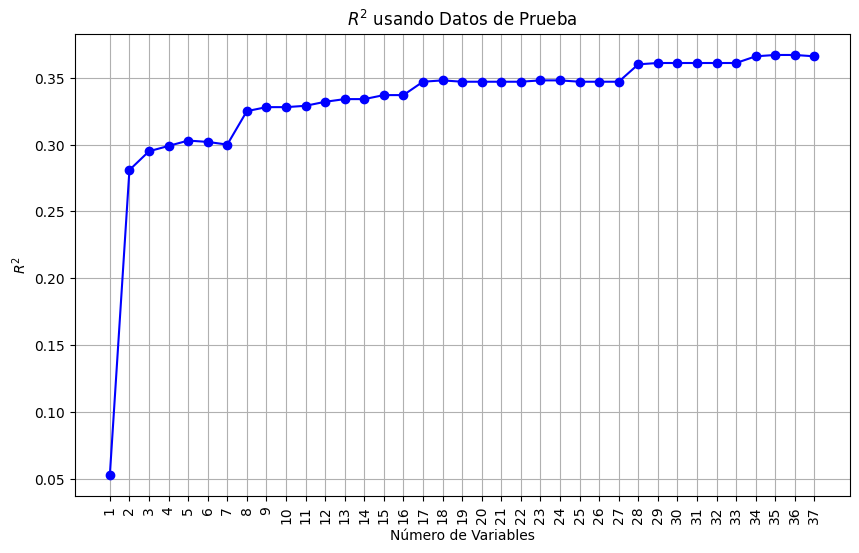

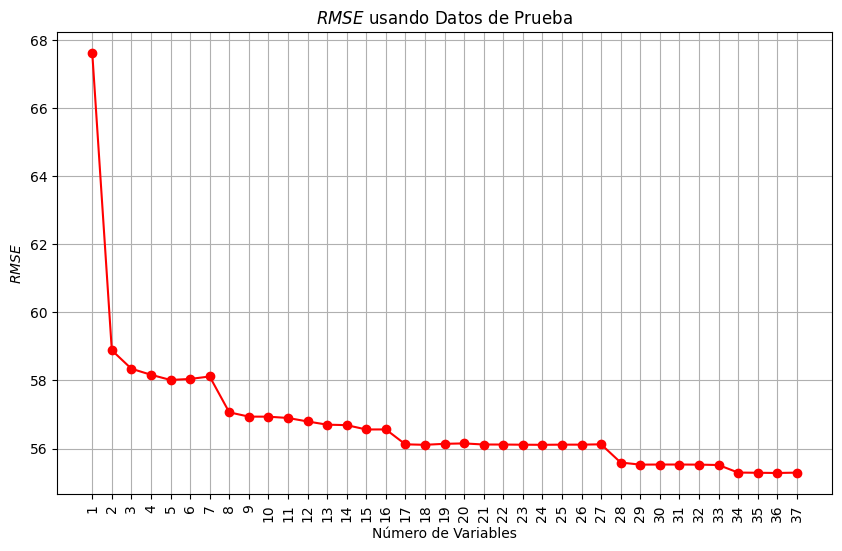

In [409]:
modelo_regresion_lineal_37_feautures = linear_regression_model(XtrainScaled, XtestScaled, y_train, y_test)
modelo_regresion_lineal_37_feautures

In [410]:
# creamos una función que instancia un modelo de regresión polinomica, según el número de los grados que mejor se ajuste al R2 y al RMSE
def polinomial_regression_model(XtrainScaled, XtestScaled, y_train, y_test, grados):
  lre = LinearRegression()
  Rsqu_test = []
  order = np.arange(1,grados+1)
  for n in order:
      pr = PolynomialFeatures(degree=n)
      X_train_pr = pr.fit_transform(XtrainScaled[:, :XtrainScaled.shape[1] + 1])
      X_test_pr = pr.fit_transform(XtestScaled[:, :XtrainScaled.shape[1] + 1])
      lre.fit(X_train_pr, y_train)
      Rsqu_test.append(lre.score(X_test_pr, y_test))

  print(Rsqu_test)
  plt.figure(figsize=(10, 6))
  plt.plot(order, Rsqu_test)
  plt.xlabel('order')
  plt.ylabel('R^2')
  plt.title('R^2 Using Test Data')
  plt.show();



[0.36643429263456284, -2.931379811945743e+17]


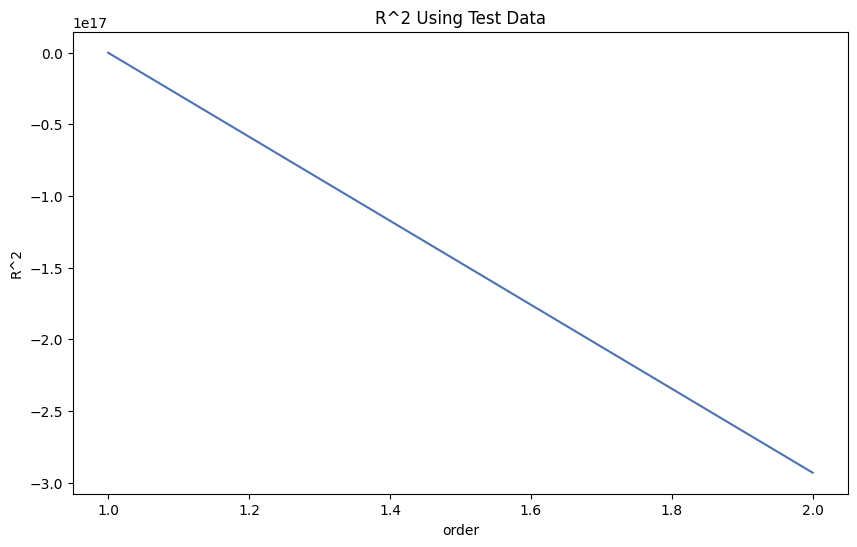

In [411]:
polinomical_37_feautures_2grados = polinomial_regression_model(XtrainScaled, XtestScaled, y_train, y_test,2) # colocamos un grado 2 para este caso
polinomical_37_feautures_2grados

In [412]:
def summary_ols(XtrainScaled, y_train, y_test):
  for n in np.arange(1, XtrainScaled.shape[1] + 1):  # Empieza desde 1 porque n=0 no tiene sentido aquí.
      # Seleccionamos las primeras `n` columnas de X_var
      X = XtrainScaled[:, :n]
      y = y_train

      # Añadimos una columna de 1s para el intercepto
      X = sm.add_constant(X)  # Agrega una columna de 1s como el intercepto

      # Creamos el modelo
      model = sm.OLS(y_train, X)
      results = model.fit()

      # Predicciones y evaluación
      y_pred = results.predict(X)  # Usamos el mismo conjunto para predicción y evaluación
      rmse = np.sqrt(((y_test - y_pred) ** 2).mean()).round(3)
      r_squared = results.rsquared
      # Mostramos el resumen del modelo
  print("El siguiente cuadro nos muestra un resumen de todas las variables y su importancia si tenemos en cuenta el p-valor")
  print("El R2 es:", round(r_squared, 2))
  print(results.summary())

In [413]:
# mostramos el resumen con statsmodel
# nos indica en la columna del p-valor... la relevancia de la variable para el modelo
resumen_ols_37_features = summary_ols(XtrainScaled, y_train, y_test)
resumen_ols_37_features

El siguiente cuadro nos muestra un resumen de todas las variables y su importancia si tenemos en cuenta el p-valor
El R2 es: 0.6
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     465.1
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:06:36   Log-Likelihood:                -55722.
No. Observations:               11664   AIC:                         1.115e+05
Df Residuals:                   11626   BIC:                         1.118e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

In [414]:
# vamos a probar reduciendo la dimensionalidad según el p-valor
# nos quedaremos con valores que representen menos de un 0.15 del p valor
columnas_representativas = [0,1,2,3,4,7,8,10,11,13,14,15,16,17,18,19,20,21,24,25,27,28,33,34,35,36]
XtrainScaled_reduced = XtrainScaled[:, columnas_representativas]
XtestScaled_reduced = XtestScaled[:, columnas_representativas]

print("Tomamos",len(columnas_representativas), "variables para poner a prueba el modelo")

Tomamos 26 variables para poner a prueba el modelo


R2 cuando tomamos 1 variable/s es: 0.053 y RMSE cuando tomamos 1 variable/s es: 67.617

R2 cuando tomamos 2 variable/s es: 0.281 y RMSE cuando tomamos 2 variable/s es: 58.887

R2 cuando tomamos 3 variable/s es: 0.295 y RMSE cuando tomamos 3 variable/s es: 58.345

R2 cuando tomamos 4 variable/s es: 0.299 y RMSE cuando tomamos 4 variable/s es: 58.168

R2 cuando tomamos 5 variable/s es: 0.303 y RMSE cuando tomamos 5 variable/s es: 58.015

R2 cuando tomamos 6 variable/s es: 0.33 y RMSE cuando tomamos 6 variable/s es: 56.85

R2 cuando tomamos 7 variable/s es: 0.333 y RMSE cuando tomamos 7 variable/s es: 56.743

R2 cuando tomamos 8 variable/s es: 0.334 y RMSE cuando tomamos 8 variable/s es: 56.701

R2 cuando tomamos 9 variable/s es: 0.336 y RMSE cuando tomamos 9 variable/s es: 56.6

R2 cuando tomamos 10 variable/s es: 0.336 y RMSE cuando tomamos 10 variable/s es: 56.587

R2 cuando tomamos 11 variable/s es: 0.34 y RMSE cuando tomamos 11 variable/s es: 56.454

R2 cuando tomamos 12 variable/s e

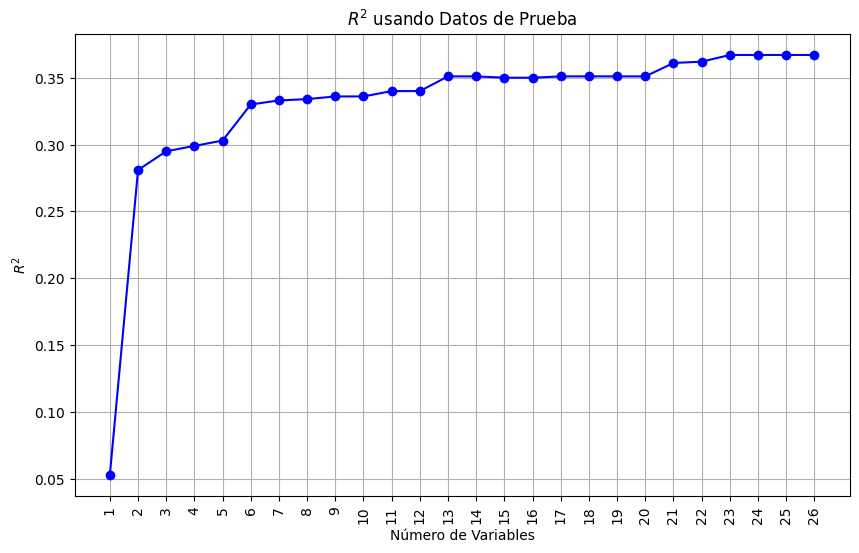

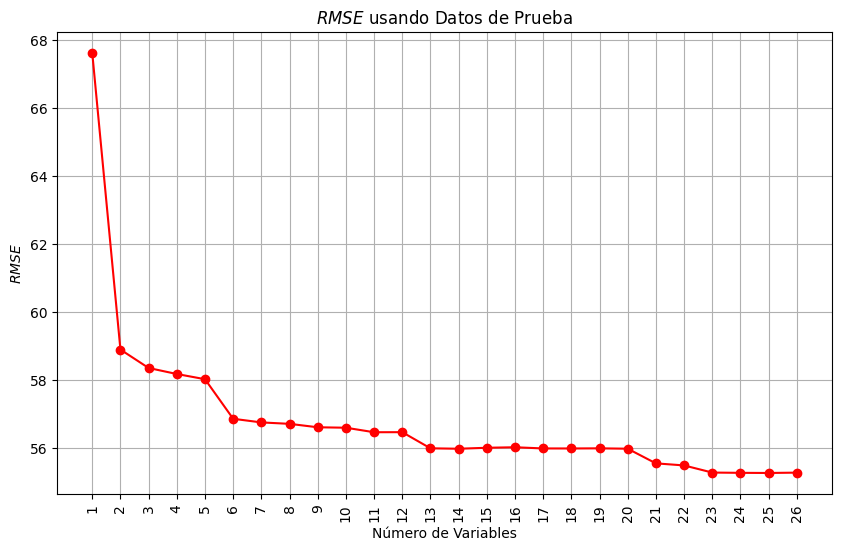

In [415]:
# probamos de nuevo el modelo, ahora con 26 variables
modelo_26_features_regression = linear_regression_model(XtrainScaled_reduced, XtestScaled_reduced, y_train, y_test)
modelo_26_features_regression

[0.3671011913488442, 0.40785867964775024]


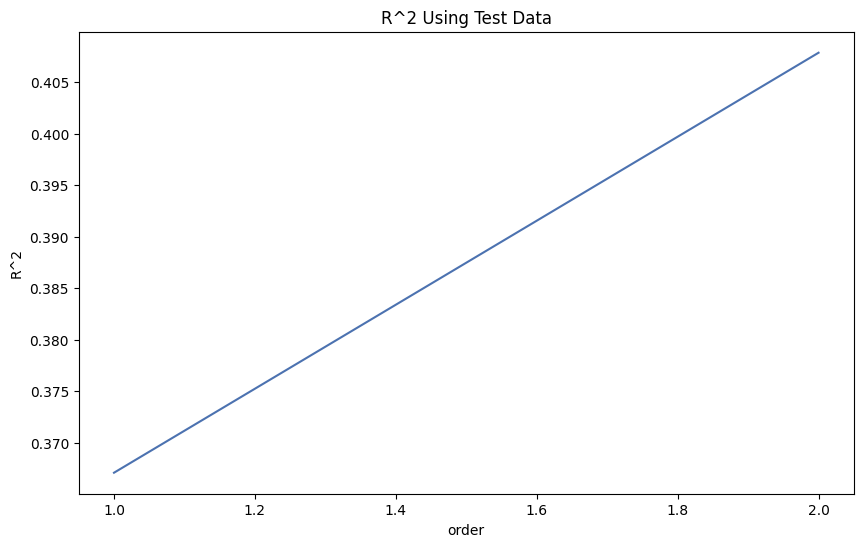

In [416]:
# probamos el modelo con polinomico con la reduccion de features
# el modelo polinomico de segundo grado con la reduccion de dimensionalidad funciona mejor en cuanto al valor R2
# para mas de 2 grados el modelo pierde fuerza
regresion_polinomica_2grados =polinomial_regression_model(XtrainScaled_reduced, XtestScaled_reduced, y_train, y_test,2)
regresion_polinomica_2grados

In [417]:
resumen_ols_26_features = summary_ols(XtrainScaled_reduced, y_train, y_test)
resumen_ols_26_features

El siguiente cuadro nos muestra un resumen de todas las variables y su importancia si tenemos en cuenta el p-valor
El R2 es: 0.59
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     650.8
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:06:41   Log-Likelihood:                -55783.
No. Observations:               11664   AIC:                         1.116e+05
Df Residuals:                   11637   BIC:                         1.118e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [418]:
column_names = ['0-Host Total Listings Count', '1-Accommodates', '2-Bedrooms',
       '3-Bathrooms', '4-Beds', '5-Guests Included', '6-Security Deposit',
       '7-Cleaning Fee', '8-Extra People', '9-Minimum Nights', '10-Availability 365',
       '11-Number of Reviews', '12-Host_antiguedad_anios', '13-Country Code_AT',
       '14-Country Code_AU', '15-Country Code_DE', '16-Country Code_ES',
       '17-Country Code_FR', '18-Country Code_GB', '19-Country Code_IE',
       '20-Country Code_IT', '21-Country Code_NL', '22-Property Type_Apartment',
       '23-Property Type_Bed & Breakfast', '24-Property Type_Condominium',
       '25-Property Type_House', '26-Property Type_Loft',
       '27-Room Type_Entire home/apt', '28-Room Type_Private room',
       '29-Bed Type_Airbed', '30-Bed Type_Couch', '31-Bed Type_Futon',
       '32-Bed Type_Pull-out Sofa', '33-Cancellation Policy_flexible',
       '34-Cancellation Policy_moderate', '35-Cancellation Policy_strict',
       '36-Cancellation Policy_super_strict_30']

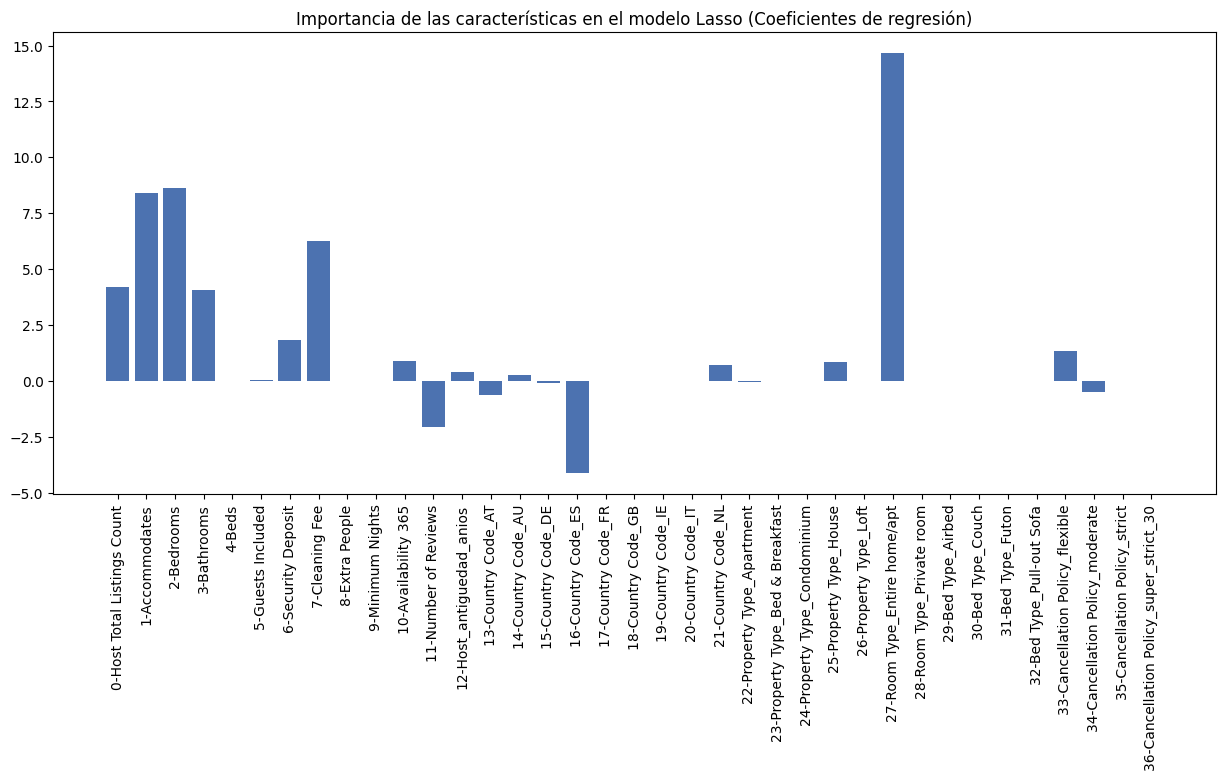

[ 4.20802586  8.40226246  8.61490984  4.0482366   0.          0.03198843
  1.83661319  6.24457564 -0.         -0.          0.89779587 -2.04224755
  0.40282791 -0.65098408  0.2571969  -0.10734948 -4.13237192 -0.
  0.          0.         -0.          0.69066469 -0.03746544 -0.
  0.          0.8426084   0.         14.65706482 -0.          0.
 -0.         -0.         -0.          1.32809858 -0.4766559  -0.
 -0.        ]
Columnas que Lasso recomienda eliminar del modelo (coeficientes 0): ['4-Beds', '8-Extra People', '9-Minimum Nights', '17-Country Code_FR', '18-Country Code_GB', '19-Country Code_IE', '20-Country Code_IT', '23-Property Type_Bed & Breakfast', '24-Property Type_Condominium', '26-Property Type_Loft', '28-Room Type_Private room', '29-Bed Type_Airbed', '30-Bed Type_Couch', '31-Bed Type_Futon', '32-Bed Type_Pull-out Sofa', '35-Cancellation Policy_strict', '36-Cancellation Policy_super_strict_30']
Columnas que quedan en el modelo: ['0-Host Total Listings Count', '1-Accommodates', '

In [419]:

  # Instanciamos el modelo lineal usando lasso
  lasso = Lasso()

  # entrenamos el modelo con los datos
  lasso.fit(XtrainScaled, y_train)

  # calculamos los coeficientes
  lasso_coef = lasso.coef_


  plt.figure(figsize=(15, 6))
  plt.bar(column_names, lasso_coef)
  plt.xticks(rotation=90)
  plt.title("Importancia de las características en el modelo Lasso (Coeficientes de regresión)")
  plt.show();
  # Las características con coeficientes cercanos a 0 son menos relevantes para el modelo.
  print(lasso_coef)

  columnas_a_eliminar = [col for col, coef in zip(column_names, lasso.coef_) if coef == 0]
  print("Columnas que Lasso recomienda eliminar del modelo (coeficientes 0):", columnas_a_eliminar)
  print("Columnas que quedan en el modelo:", [col for col, coef in zip(column_names, lasso.coef_) if coef != 0])


In [420]:
columnas_a_conservar_lasso = [0,1,2,6,7,10,11,16,21,27,33,34]
len(columnas_a_conservar_lasso)
X_trainScaledLasso = XtrainScaled[:, columnas_a_conservar_lasso]
X_testScaledLasso = XtestScaled[:, columnas_a_conservar_lasso]

[0.3429668259327048, 0.3721486076340027]


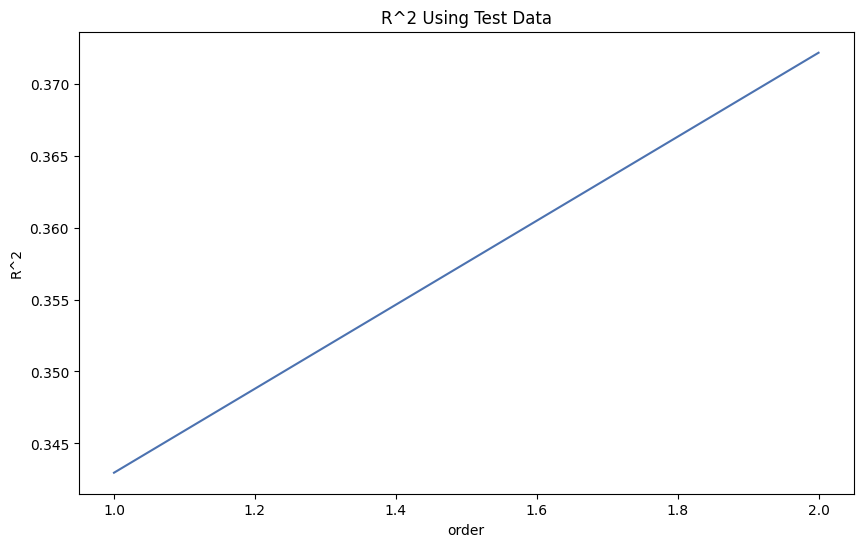

In [421]:
# probamos la regresion_lineal_lasso
modelo_regresion_lineal_lasso = polinomial_regression_model(X_trainScaledLasso, X_testScaledLasso, y_train, y_test,2)
modelo_regresion_lineal_lasso

In [422]:
def summary_lasso(X_trainScaledLasso, X_testScaledLasso, y_train, y_test):
    scores_l = []
    alphas = [0.001, 0.01, 0.10, 1, 10, 100, 1000]  # Valores de alpha a probar

    for alpha in alphas:
        # Entrenamos un modelo de Lasso con cada valor de alpha
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_trainScaledLasso, y_train)

        # Guardamos el R^2 en el conjunto de prueba
        scores_l.append(round(lasso.score(X_testScaledLasso, y_test),4))

    # Generamos el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, scores_l, marker='o', label="Score")
    plt.xscale("log")  # Escala logarítmica en el eje X
    plt.xlabel('alpha (escala log)')
    plt.ylabel('Scores')
    plt.title('Scores Regresion Lasso')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

    # Imprimimos los valores R^2 para cada alpha
    print(f"Scores (R^2) para cada valor de  alpha: {scores_l}")


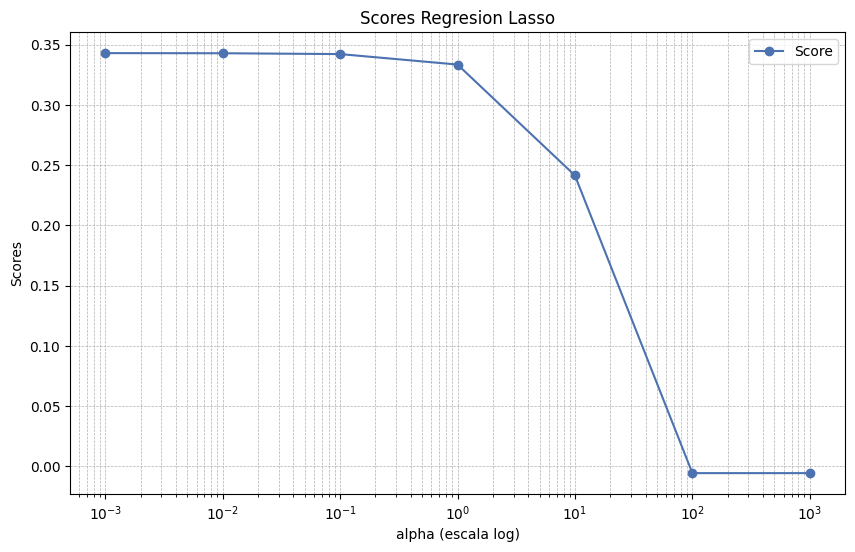

Scores (R^2) para cada valor de  alpha: [0.343, 0.3429, 0.3422, 0.3335, 0.2414, -0.0057, -0.0057]


In [423]:
valores_alpha_lasso = summary_lasso(X_trainScaledLasso,X_testScaledLasso ,y_train, y_test)
valores_alpha_lasso

In [424]:
# comprobamos las predicciones y el error
# Creamos el modelo de regresión lineal
def grafico_residuos(X_trainScaledLasso, X_testScaledLasso, y_train, y_test):
  reg = LinearRegression()

  # Ajustamos el modelo a los datos de entrenamiento
  reg.fit(X_trainScaledLasso, y_train)
  y_pred = reg.predict(X_testScaledLasso)
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_test - y_pred)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores reales")
  plt.ylabel("Errores (Residuos)")
  plt.title(f"Residuos para {X_testScaledLasso.shape[1]} variables")
  plt.show();

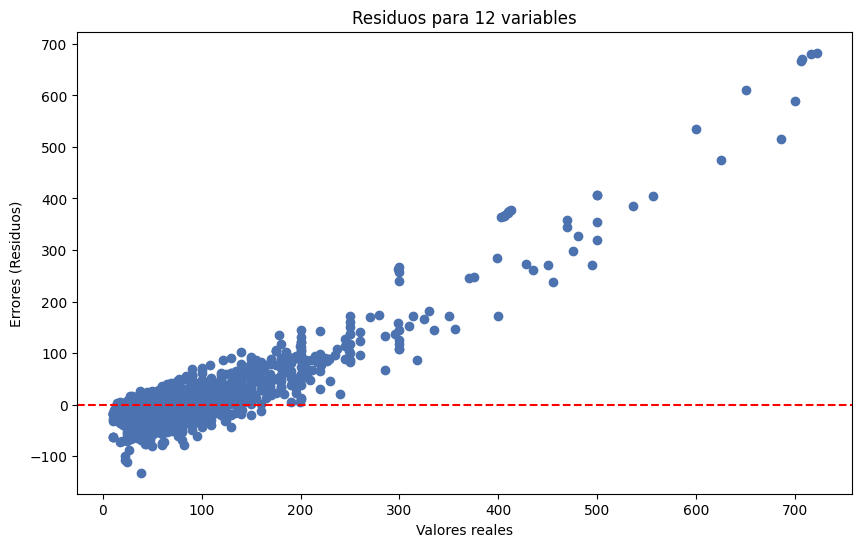

In [425]:
grafico_residuos_20_features = grafico_residuos(X_trainScaledLasso, X_testScaledLasso, y_train, y_test)

# **Interpretación de los residuos:**

Idealmente, los residuos deberían ser **próximos a cero** (línea roja).  
La **tendencia ascendente** observada cuando los residuos son más altos indica que los **valores extremos** podrían estar **perjudicando la eficiencia del modelo**.

## **Análisis de la Distribución Observada**

Este fenómeno, a modo de intuición, podría explicarse por el hecho de que el dataset contiene datos de países con muy poca representatividad (es decir, pocos registros), pero con valores muy altos. Esto podría estar causando la distribución y la dispersión observada en el gráfico anterior.


In [426]:
# vamos a aplicar al modelo de regresion el metodo Ridge
def ridge_model(X_trainScaledLasso, X_testScaledLasso, y_train, y_test):
  Rsqu_test = []
  Rsqu_train = []
  dummy1 = []
  Alpha = 10 * np.array(range(0,1000))
  pbar = tqdm(Alpha) # nos ayuda a visualizar las iteraciones y ver en tiempo real los valores fluctuantes de score

  for alpha in pbar:
      RigeModel = Ridge(alpha=alpha)
      RigeModel.fit(X_trainScaledLasso, y_train)
      test_score, train_score = RigeModel.score(X_testScaledLasso, y_test), RigeModel.score(X_trainScaledLasso, y_train)

      pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

      Rsqu_test.append(test_score)
      Rsqu_train.append(train_score)



  if test_score < 0.70 and train_score < 0.70:
    print(f"\nEl test score es: {test_score}, el modelo puede estar sufriendo de underfitting, no es capaz de generalizar y es muy simple.")
    print(f"\nEl train score es: {train_score}, el modelo puede estar sufriendo de overfitting, generalizando mal... no captura los patrones.")
  elif test_score < 0.70:
        print(f"\nEl test score es: {test_score}, el modelo puede estar sufriendo de underfitting, no es capaz de generalizar y es muy simple.")
  elif train_score < 0.70:
        print(f"\nEl train score es: {train_score}, el modelo puede estar sufriendo de overfitting, generalizando mal... no captura los patrones.")
  else:
    print("El resultado del modelo es bueno, generaliza bien.")
  plt.figure(figsize=(10, 6))
  plt.plot(Alpha, Rsqu_test, label='Datos de validación')
  plt.plot(Alpha, Rsqu_train, 'r', label='Datos de entrenamiento')
  plt.xlabel('alpha')
  plt.ylabel('R^2')
  plt.ylim(0, 1)
  plt.legend()

100%|██████████| 1000/1000 [00:13<00:00, 71.82it/s, Test Score=0.296, Train Score=0.532]



El test score es: 0.29583727528984427, el modelo puede estar sufriendo de underfitting, no es capaz de generalizar y es muy simple.

El train score es: 0.5324961298840258, el modelo puede estar sufriendo de overfitting, generalizando mal... no captura los patrones.


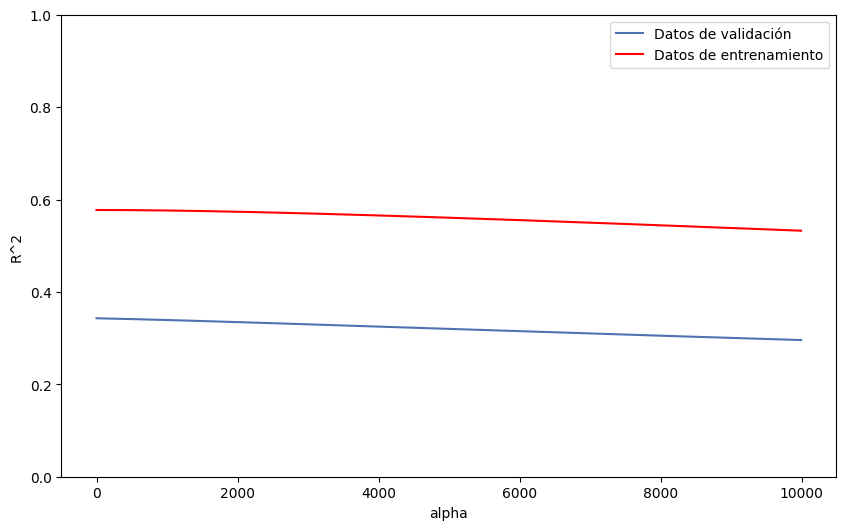

In [427]:
ridge_model(X_trainScaledLasso, X_testScaledLasso, y_train, y_test)

In [428]:
resumen_14_features = summary_ols(X_trainScaledLasso, y_train, y_test)
resumen_14_features

El siguiente cuadro nos muestra un resumen de todas las variables y su importancia si tenemos en cuenta el p-valor
El R2 es: 0.58
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1326.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:06:58   Log-Likelihood:                -55996.
No. Observations:               11664   AIC:                         1.120e+05
Df Residuals:                   11651   BIC:                         1.121e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

## Preparación de los Datos

Hasta este punto, se han realizado varias tareas de preprocesamiento en los datos:

- **Escalado de los datos**: Los valores han sido escalados para asegurar que todas las características tengan una escala similar.
- **Imputación de valores nulos**: Se han manejado los valores faltantes mediante técnicas de imputación apropiadas.
- **Eliminación de columnas con datos faltantes**: Se eliminaron las columnas o características que contenían más del 25% de datos faltantes (NaN).

En este análisis, me enfocaré en los **datos de España**, ya que este país representa aproximadamente el **90%** del conjunto de datos. Este sesgo hacia España podría estar afectando la capacidad del modelo para generalizar, ya que el modelo podría estar aprendiendo patrones específicos del país debido a la alta representación de los datos españoles. Además, la presencia de valores atípicos o extremos de otros países podría estar introduciendo **ruido** en el modelo, lo que podría dificultar su desempeño general.


In [429]:
airbnb_data.columns

Index(['Price', 'Host Total Listings Count', 'Accommodates', 'Bedrooms',
       'Bathrooms', 'Beds', 'Guests Included', 'Security Deposit',
       'Cleaning Fee', 'Extra People', 'Minimum Nights', 'Availability 365',
       'Number of Reviews', 'Host_antiguedad_anios', 'City', 'State',
       'Country Code_AT', 'Country Code_AU', 'Country Code_DE',
       'Country Code_ES', 'Country Code_FR', 'Country Code_GB',
       'Country Code_IE', 'Country Code_IT', 'Country Code_NL',
       'Property Type_Apartment', 'Property Type_Bed & Breakfast',
       'Property Type_Condominium', 'Property Type_House',
       'Property Type_Loft', 'Room Type_Entire home/apt',
       'Room Type_Private room', 'Bed Type_Airbed', 'Bed Type_Couch',
       'Bed Type_Futon', 'Bed Type_Pull-out Sofa',
       'Cancellation Policy_flexible', 'Cancellation Policy_moderate',
       'Cancellation Policy_strict', 'Cancellation Policy_super_strict_30'],
      dtype='object')

In [430]:
columnas_new_model = ['Price', 'Host Total Listings Count', 'Accommodates', 'Bedrooms',
       'Bathrooms', 'Beds', 'Guests Included', 'Security Deposit',
       'Cleaning Fee', 'Extra People', 'Minimum Nights', 'Availability 365',
       'Number of Reviews', 'Host_antiguedad_anios', 'City', 'State',
       'Country Code_ES', 'Property Type_Apartment', 'Property Type_Bed & Breakfast',
       'Property Type_Condominium', 'Property Type_House',
       'Property Type_Loft', 'Room Type_Entire home/apt',
       'Room Type_Private room', 'Bed Type_Airbed', 'Bed Type_Couch',
       'Bed Type_Futon', 'Bed Type_Pull-out Sofa',
       'Cancellation Policy_flexible', 'Cancellation Policy_moderate',
       'Cancellation Policy_strict', 'Cancellation Policy_super_strict_30']

In [431]:
airbnb_data = airbnb_data[columnas_new_model]
airbnb_data = airbnb_data[airbnb_data["Country Code_ES"] == 1]
airbnb_test = airbnb_test[columnas_new_model]
airbnb_test = airbnb_test[airbnb_test["Country Code_ES"] == 1]



In [432]:
airbnb_data_esp = airbnb_data.drop(columns = ["Country Code_ES", "City", "State"])
airbnb_test_esp = airbnb_test.drop(columns = ["Country Code_ES", "City", "State"])

In [433]:
# Dataset de train
data_train = airbnb_data_m
y_train_esp = airbnb_data_esp.iloc[:, 0].values.reshape(-1,1)
X_train_esp = airbnb_data_esp.iloc[:, 1:].values

In [434]:
# Dataset de test
data_test = airbnb_test_m
y_test_esp = airbnb_test_esp.iloc[:, 0].values.reshape(-1,1)
X_test_esp = airbnb_test_esp.iloc[:, 1:].values

In [435]:
# Escalamos (con los datos de train)
scaler_esp = preprocessing.StandardScaler().fit(X_train_esp)
XtrainScaled_esp = scaler_esp.transform(X_train_esp)

# La normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled_esp = scaler_esp.transform(X_test_esp)

In [436]:
# comprobamos las dimensiones de los arrays
print(X_test_esp.shape, "---> X_test")
print(y_test_esp.shape, "----> y_test")
print(X_train_esp.shape, "----> X_train")
print(y_train_esp.shape, "----> y_train")


(2780, 28) ---> X_test
(2780, 1) ----> y_test
(11167, 28) ----> X_train
(11167, 1) ----> y_train


R2 cuando tomamos 1 variable/s es: 0.062 y RMSE cuando tomamos 1 variable/s es: 65.767

R2 cuando tomamos 2 variable/s es: 0.299 y RMSE cuando tomamos 2 variable/s es: 56.864

R2 cuando tomamos 3 variable/s es: 0.312 y RMSE cuando tomamos 3 variable/s es: 56.329

R2 cuando tomamos 4 variable/s es: 0.317 y RMSE cuando tomamos 4 variable/s es: 56.144

R2 cuando tomamos 5 variable/s es: 0.319 y RMSE cuando tomamos 5 variable/s es: 56.028

R2 cuando tomamos 6 variable/s es: 0.318 y RMSE cuando tomamos 6 variable/s es: 56.086

R2 cuando tomamos 7 variable/s es: 0.314 y RMSE cuando tomamos 7 variable/s es: 56.235

R2 cuando tomamos 8 variable/s es: 0.337 y RMSE cuando tomamos 8 variable/s es: 55.307

R2 cuando tomamos 9 variable/s es: 0.342 y RMSE cuando tomamos 9 variable/s es: 55.103

R2 cuando tomamos 10 variable/s es: 0.342 y RMSE cuando tomamos 10 variable/s es: 55.102

R2 cuando tomamos 11 variable/s es: 0.344 y RMSE cuando tomamos 11 variable/s es: 55.021

R2 cuando tomamos 12 variabl

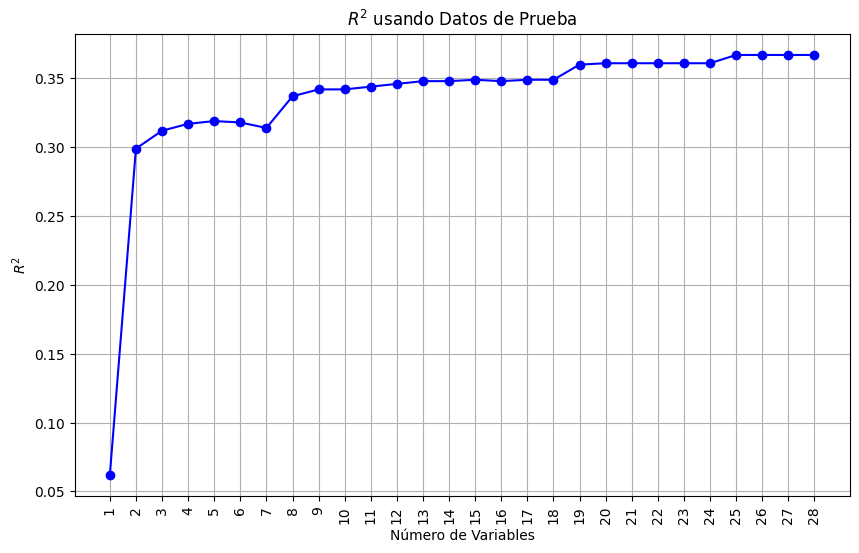

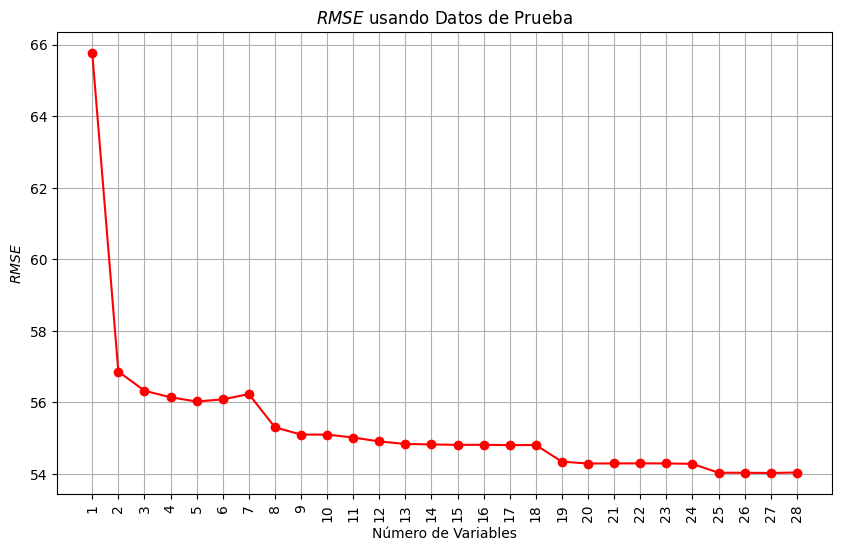

In [437]:
# probamos el modelo de regresion lineal con los nuevos datos para España
# se pudo reducir el RMSE a costa de tener un R2 un poco más bajo
linear_regression_model(XtrainScaled_esp, XtestScaled_esp, y_train_esp, y_test_esp)

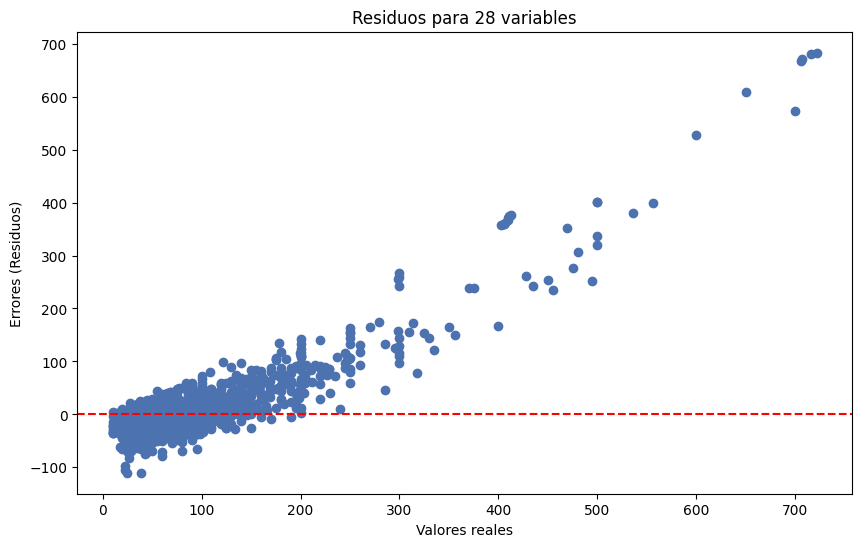

In [438]:
grafico_residuos(XtrainScaled_esp, XtestScaled_esp, y_train_esp, y_test_esp)

In [439]:
XtrainScaled_esp.shape

(11167, 28)

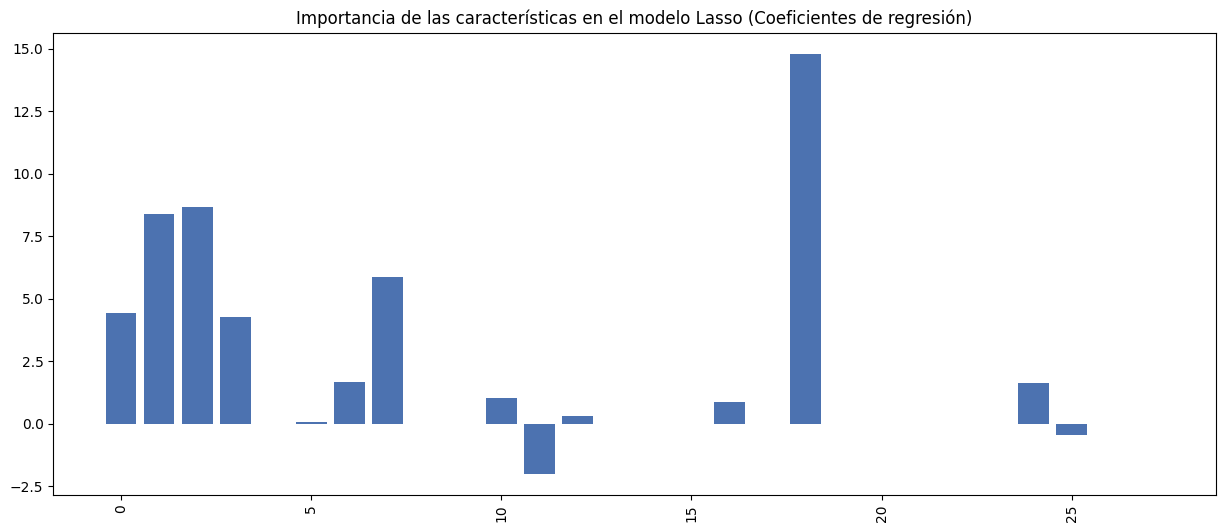

[ 4.42422041  8.39684038  8.65784428  4.28744918  0.          0.06476607
  1.65981523  5.88219677 -0.         -0.          1.01437229 -1.99725521
  0.31944365 -0.         -0.          0.          0.88008719  0.
 14.80651987 -0.          0.         -0.         -0.         -0.
  1.64210697 -0.45434507 -0.         -0.        ]
Columnas que Lasso recomienda eliminar del modelo (coeficientes 0): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Columnas que quedan en el modelo: [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 16, 18, 24, 25]


In [440]:
  # Instanciamos el modelo lineal usando lasso con datos de españa
  lasso = Lasso()

  # entrenamos el modelo con los datos
  lasso.fit(XtrainScaled_esp, y_train_esp)

  # calculamos los coeficientes
  lasso_coef = lasso.coef_


  plt.figure(figsize=(15, 6))
  plt.bar(np.arange(0,28,1), lasso_coef)
  plt.xticks(rotation=90)
  plt.title("Importancia de las características en el modelo Lasso (Coeficientes de regresión)")
  plt.show();
  # Las características con coeficientes cercanos a 0 son menos relevantes para el modelo.
  print(lasso_coef)

  columnas_a_eliminar = [col for col, coef in zip(np.arange(0,28,1), lasso.coef_) if coef == 0]
  print("Columnas que Lasso recomienda eliminar del modelo (coeficientes 0):", np.arange(0,28,1))
  print("Columnas que quedan en el modelo:", [col for col, coef in zip(np.arange(0,28,1), lasso.coef_) if coef != 0])

In [441]:

# Crear el modelo de regresión lineal
reg = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
reg.fit(XtrainScaled_esp, y_train_esp)

# R² para los datos de test
r2_test = reg.score(XtestScaled_esp, y_test_esp)
print(f'R² para los datos de test: {r2_test}')

# R² para los datos de train
r2_train = reg.score(XtrainScaled_esp, y_train_esp)
print(f'\nR² para los datos de train: {r2_train}')

# R² con validación cruzada de 4 pliegues en los datos de entrenamiento
Rcross_train = cross_val_score(reg, XtrainScaled_esp, y_train_esp, cv=4)
print("\nLa media de R² de los pliegues en entrenamiento es", Rcross_train.mean(), "y la desviación estándar es:", Rcross_train.std())

# Predicciones con validación cruzada sobre los datos de train
y_predictado_train_esp = cross_val_predict(reg, XtrainScaled_esp, y_train_esp, cv=4)
print(f'\nPredicciones del modelo con training: {y_predictado_train_esp}')

# Predicciones con cv sobre los datos de test, predccion final sobre el modelo
y_predictado_test_esp = cross_val_predict(reg, XtestScaled_esp, y_test_esp, cv=4)
print(f'\nPredicciones del modelo con test: {y_predictado_test_esp}')


R² para los datos de test: 0.36677714890743707

R² para los datos de train: 0.5906745226361152

La media de R² de los pliegues en entrenamiento es 0.5877932597685136 y la desviación estándar es: 0.02723557171210634

Predicciones del modelo con training: [[67.89696408]
 [79.80104983]
 [38.1200725 ]
 ...
 [63.90508903]
 [30.95949779]
 [71.20647808]]

Predicciones del modelo con test: [[ 55.55749397]
 [115.42046286]
 [147.25438525]
 ...
 [ 28.65610752]
 [ 42.53716343]
 [165.72178066]]


In [442]:
import matplotlib.pyplot as plt
import numpy as np
def Grafico_distribucion(funcion_roja, funcion_azul, etiqueta_roja, etiqueta_azul, titulo):
    # Tamaño de la figura
    plt.figure(figsize=(10, 6))

    # Graficamos la primera función en rojo (KDE)
    sns.kdeplot(funcion_roja, label=etiqueta_roja, color = "red", marker = ".")

    # Graficamos la segunda función en azul (KDE)
    sns.kdeplot(funcion_azul, label=etiqueta_azul, color = "blue")

    # Agregamos el título y las etiquetas de los ejes
    plt.title(titulo)
    plt.xlabel('Precio')
    plt.ylabel('Proporción')

    # Mostrar la leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show();


### Comparación de Distribuciones: Valores Reales vs Predichos  
El gráfico muestra la distribución de **valores reales** (línea punteada) y **valores predichos** (línea continua) en el conjunto de entrenamiento. Ambas distribuciones de cierta manera semejantes graficamente, indicando que posiblemente puede haber un buen ajuste del modelo.


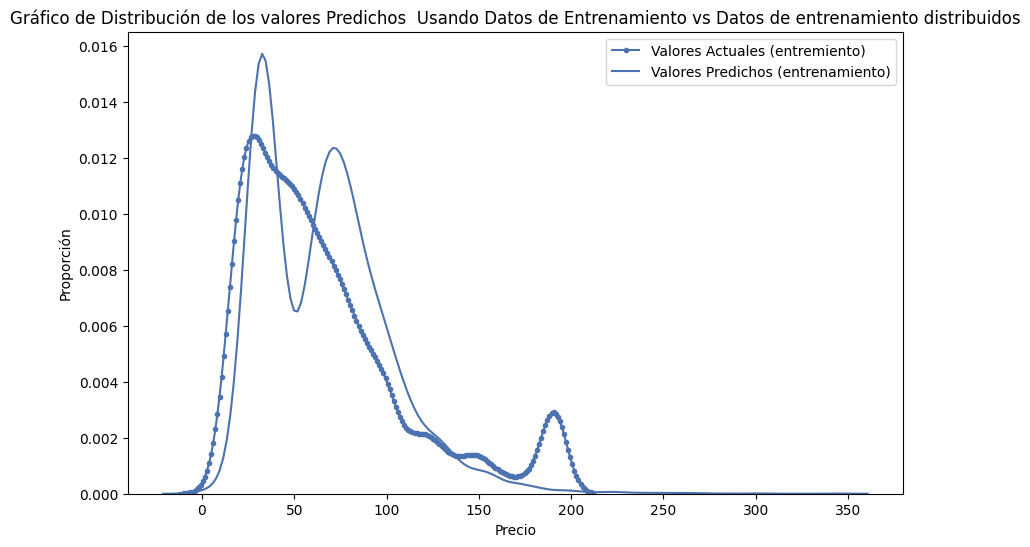

In [443]:
titulo = 'Gráfico de Distribución de los valores Predichos  Usando Datos de Entrenamiento vs Datos de entrenamiento distribuidos'
Grafico_distribucion(y_train_esp, y_predictado_train_esp, "Valores Actuales (entremiento)", "Valores Predichos (entrenamiento)", titulo)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45

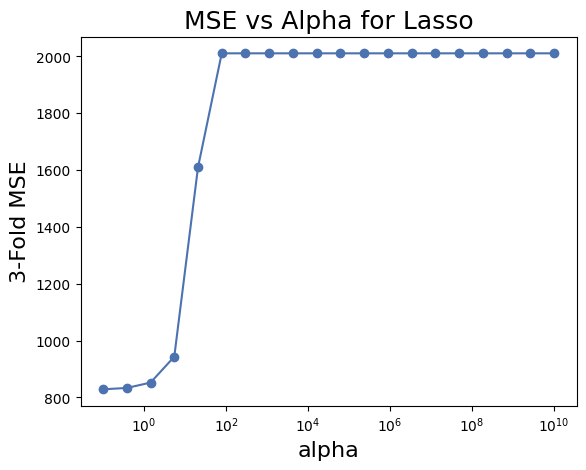

In [444]:

# Definimos el rango de valores para 'alpha' en una escala logarítmica
alpha_vector = np.logspace(-1, 10, 20)

# Definimos el parámetro grid para el GridSearchCV
param_grid = {'alpha': alpha_vector}

# Definimos el modelo Lasso y configuramos GridSearchCV
grid = GridSearchCV(Lasso(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=3, verbose=2)

# Ajustamos el modelo con los datos de entrenamiento
grid.fit(XtrainScaled_esp, y_train_esp)

# Mostramos los mejores resultados de la validación cruzada
print("Best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

# Convertimos el resultado de la validación cruzada (negativo) a positivo
scores = -1 * np.array(grid.cv_results_['mean_test_score'])

# Graficamos los resultados con escala logarítmica para 'alpha'
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('3-Fold MSE', fontsize=16)
plt.title('MSE vs Alpha for Lasso', fontsize=18)
plt.show()

In [445]:
rmse = round(np.sqrt(828.288), 2)
print("RMSE: {:.3f}".format(rmse))
print(f"El erro medio aplicando validazion cruzada es de {rmse}, es decir de media el modelo falla en predicir el precio en {rmse} euros")

RMSE: 28.780
El erro medio aplicando validazion cruzada es de 28.78, es decir de media el modelo falla en predicir el precio en 28.78 euros


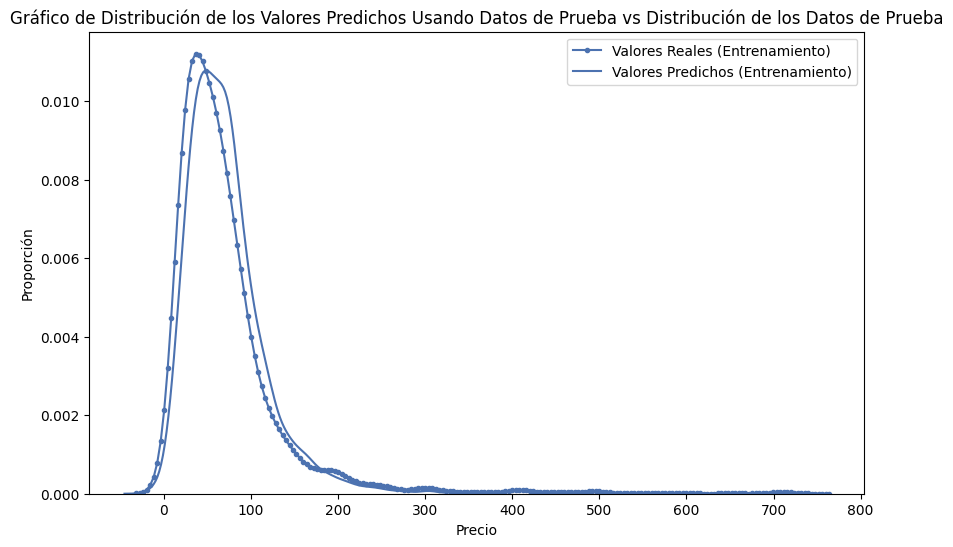

In [446]:
titulo = "Gráfico de Distribución de los Valores Predichos Usando Datos de Prueba vs Distribución de los Datos de Prueba"
Grafico_distribucion(y_test_esp, y_predictado_test_esp, "Valores Reales (Entrenamiento)", "Valores Predichos (Entrenamiento)", titulo)

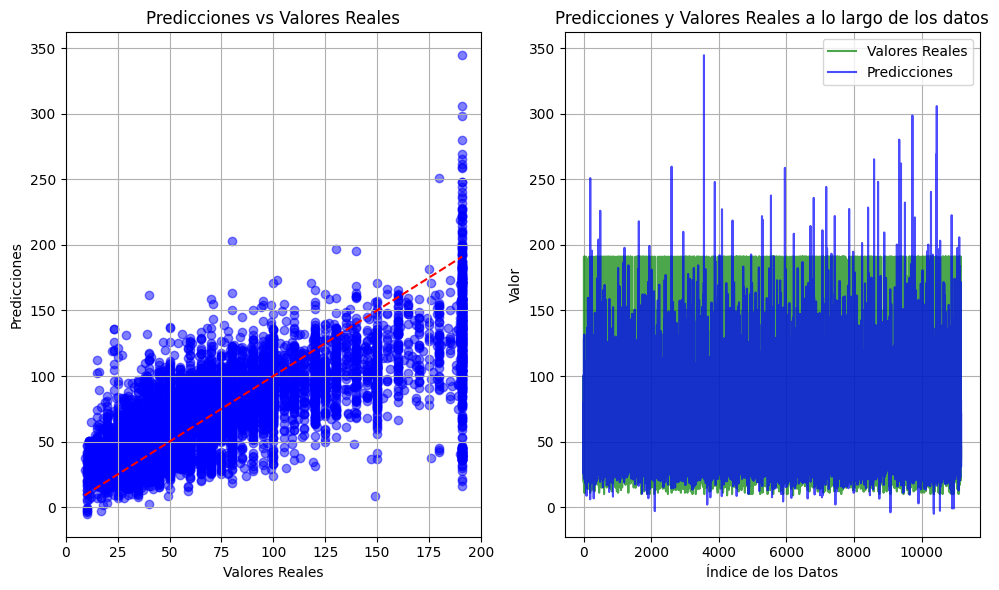

In [447]:
# Crear el gráfico de dispersión para comparar predicciones vs valores reales
plt.figure(figsize=(10, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)  # Primer gráfico (izquierda)
plt.scatter(y_train_esp, y_predictado_train_esp, color='blue', alpha=0.5)
plt.plot([min(y_train_esp), max(y_train_esp)], [min(y_train_esp), max(y_train_esp)], color='red', linestyle='--')
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.grid(True)

# Gráfico de líneas
plt.subplot(1, 2, 2)  # Segundo gráfico (derecha)
plt.plot(y_train_esp, label='Valores Reales', color='green', alpha=0.7)
plt.plot(y_predictado_train_esp, label='Predicciones', color='blue', alpha=0.7)
plt.title("Predicciones y Valores Reales a lo largo de los datos")
plt.xlabel("Índice de los Datos")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()